# Анализ рынка российского кинопроката

**Заказчик:** Министерство культуры РФ.

**Входные данные:** данные, опубликованные на портале открытых данных Министерства культуры, включая информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск. 

**Цель проекта:** проанализировать тренды российского кинопроката.

**Задачи проекта:**

- оценить качество предоставленных данных;
- выяснить структуру предоставленных данных, связи между полями разных таблиц;
- провести подготовку данных к анализу: исправить ошибки, проанализировать и заполнить пропуски, добавить расчетные поля, представить данные в удобной для анализа форме;
- проанализировать рынок российского кинопроката в разных разрезах: динамика проката по годам, влияние возрастной категории, влияние господдержки и пр.;
- дать рекомендации заказчику по результатам исследования;
- определить потенциальные риски данного исследования, возможности их устранения;  
- дать рекомендации по дальнейшему развитию данного исследования.

## Начальная подготовка

### Импорты

In [1]:
import pandas as pd
import numpy as np
import os
import re
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

### Вспомогательные функции 

In [2]:
#--------------------------------------------------------------------
# чтение датасета:
#   сначала из локального хранилища;
#   при неудаче из удаленного (добавление слеша – особенности синтаксиса)
# 
# можно попробовать завернуть read_csv в декоратор

def custom_read_csv(path_local, separator=','):
    
    path_remote = '/' + path_local

    if os.path.exists(path_local):
        return pd.read_csv(path_local, sep=separator)

    elif os.path.exists(path_remote):
        return pd.read_csv(path_remote, sep=separator)

    else:
        print('Ошибка')


#--------------------------------------------------------------------
# определение имени таблицы

def df_name(df):
    
    return [name for name in globals() if globals()[name] is df][0]


#--------------------------------------------------------------------
# первичная информация о таблице

def basic_info(df: pd.DataFrame, sample_type='sample', qnty=5):

    # заголовок (имя исследуемого датафрейма)
    
    print(f'\n\nдатафрейм {f.BOLD}{df_name(df)}{f.END}', '≋'*30)


    # метод info()
    
    print('\n\n--- метод info() ---\n')
    print(df.info())

    
    # несколько случайных записей
    
    print(f'\n\n--- метод {sample_type}({qnty}) ---' + '\n')
    
    if sample_type == 'sample':
        display(df.sample(qnty))
    elif sample_type == 'head':
        display(df.head(qnty))
    elif sample_type == 'tail':
        display(df.tail(qnty))
    else:
        print(f'{sample_type} – недопустимое значение параметра "sample_type" ')
    
    
    # метод describe()
    
    print('\n\n--- метод describe() ---\n')
    
    try:
        display(df.describe(include=np.number))
    except ValueError:
        pass

    try:
        display(df.describe(exclude=np.number))
    except ValueError:
        pass


#--------------------------------------------------------------------
# начальная обработка названий полей датафреймов

def prepare_columns_names(df: pd.DataFrame):
    
    df.columns = df.columns.str.lower()             # перевод названий в нижний регистр
    df.columns = df.columns.str.replace(' ', '_')   # замена пробелов в названиях на подчеркивание


#--------------------------------------------------------------------
# предварительная обработка полей типа object

def prepare_object_fields(df: pd.DataFrame):
    
    for i in range(len(df.dtypes)):
        if df.dtypes[i] == 'object':
            df[df.columns[i]] = df[df.columns[i]].str.lower()            # перевод значений в нижний регистр
            df[df.columns[i]] = df[df.columns[i]].str.replace('ё','е')   # замена буквы "ё" на "е"
            df[df.columns[i]] = df[df.columns[i]].str.strip()            # удаление концевых пробелов


#--------------------------------------------------------------------
# числовые значения для вертикальных bar-графиков
# ! доработать до универсальной (+ горизонтальные, + логарифмические)

def bar_annotate(ax, decimals=0, font_size=10):
    
    max_height = 0
    for p in ax.patches:
        if p.get_height() > max_height:
            max_height = p.get_height()
    
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + max_height*0.01
        value = f'{p.get_height():.{decimals}f}'
        ax.text(_x, _y, value, ha="center", fontsize=font_size)

### Вспомогательные элементы для оформления

In [3]:
#--------------------------------------------------------------------------
# пустые строки для свободного пространства при выводе на экран

def space(num=1):
    print('\n' * num)


#--------------------------------------------------------------------------
# выделение в тексте

class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

### Настройки

In [4]:
# стиль графиков

sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plot_dpi = 150                                    # dpi для рендеринга графиков
colors = ['darkcyan', 'orange', 'tomato']         # цвета для графиков


# внешний вид

pd.set_option('display.float_format', '{:.3f}'.format)
# pd.set_option('display.precision', 7)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

warnings.filterwarnings('ignore')

## Подготовка данных

### Чтение данных

In [5]:
data_movies = custom_read_csv('datasets/mkrf_movies.csv')  # данные о прокатных удостоверениях

data_shows = custom_read_csv('datasets/mkrf_shows.csv')    # данные о прокате в российских кинотеатрах

### Первичная информация о данных

In [6]:
basic_info(data_movies)

basic_info(data_shows)



датафрейм data_movies ≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋


--- метод info() ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 n

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
6035,Жаркие летние ночи,121014618,2018-07-23T12:00:00.000Z,Художественный,Императив Интертейнмент,США,Элайджа Байнум,"Дэн Фридкин, Райан Фридкин, Брэдли Томас",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.7,"драма,мелодрама,комедия"
6757,"""АРТиШОК"" анимационный альманах авторских фильмов",114001719,2019-03-07T12:00:00.000Z,Анимационный,"ООО ""Студия ""Пчела""",Россия,"Д.Великовская, Н.Лопато (псевдоним Нилова)","В.Гассиев, Ф.Пролиг",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN
5978,ЛЕОНИД ЯКОБСОН,112001418,2018-07-02T12:00:00.000Z,Документальный,"ООО ""СТУДИЯ Н+Н""",Россия,Н.Урвачева,Н.Урвачева,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,5.6,триллер
5924,50 весенних дней,121011518,2018-06-18T12:00:00.000Z,Художественный,"Каре Продюксьон, Франс 3 Синема, Национальный центр кинематографии, Нувей Аквитэн, Банк Посталь ...",Франция,Бландин Ленуар,"Антуан Гандобер, Фабрис Голдштейн, Антуан Рейн",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.1,"драма,комедия"
2428,Любовью за любовь,111025214,2014-12-24T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Т.Березанцева,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.4,мелодрама




--- метод describe() ---



,refundable_support,nonrefundable_support,budget
count,332.000,332.000,332.000
mean,11864457.831,48980988.892,127229716.684
std,24916555.264,59980117.923,188588333.115
min,0.000,0.000,0.000
25%,0.000,25000000.000,42000000.000
50%,0.000,30000000.000,68649916.000
75%,15000000.000,40375000.000,141985319.500
max,180000000.000,400000000.000,2305074303.000


,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,financing_source,ratings,genres
count,7486,7486,7486,7486,7468,7484,7477,6918,7486,332,6519,6510
unique,6772,7484,1965,8,5490,950,4811,5349,5,3,94,742
top,День святого Валентина_,221054410,2010-12-17T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",США,О.Семёнова,П.Смирнов,«16+» - для детей старше 16 лет,Министерство культуры,6.6,драма
freq,5,2,96,4520,341,2172,47,67,2851,164,312,476




датафрейм data_shows ≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋


--- метод info() ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB
None


--- метод sample(5) ---



,puNumber,box_office
2286,121026716,960353.000
414,111008715,6457303.020
482,111010215,1957738.510
2863,124004218,5486662.940
2981,126001517,175595.000




--- метод describe() ---



,puNumber,box_office
count,3158.000,3158.000
mean,120187475.322,76478696.161
std,12383941.151,240353122.823
min,111000113.000,0.000
25%,113000191.750,86239.000
50%,121013114.500,2327987.550
75%,121028317.750,23979671.025
max,224026410.000,3073568690.790


### Объединение данных в единый датафрейм

Объединению мешает разный тип полей `puNumber` в таблицах `data_movies` и `data_shows`, а преобразованию из `object` в `int` мешают нечисловые сиимволы.

Поиск строк, содержащих нечисловые символы в поле puNumber

In [7]:
data_movies.query('puNumber.str.contains("\D")')

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
804,Паранормальный Якутск,111004112,2012-08-24T12:00:00.000Z,Художественный,ИП Тимофеев К.П.,Россия,К.Тимофеев,NaN,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,NaN,NaN
1797,Курбан-роман. (История с жертвой),нет,2014-05-15T12:00:00.000Z,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN


Уточнение проблемы в строке 804 с `puNumber = 111004112`

In [8]:
data_movies.puNumber.value_counts().sort_index().head(3)

 111004112    1
111000110     1
111000111     1
Name: puNumber, dtype: int64

Уточнение проблемы в строке 1797 с `puNumber = нет`

In [9]:
data_movies[data_movies.title.str.contains('Курбан-роман')]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
1797,Курбан-роман. (История с жертвой),нет,2014-05-15T12:00:00.000Z,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN
2078,Курбан-роман. (История с жертвой).,111009614,2014-09-02T12:00:00.000Z,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN


> Поле `puNumber` в таблице `data_movies` имеет тип `object`, а в таблице `data_shows` – тип `int`. Для объединения этих таблиц по полю `puNumber` необходимо привести данные к единому типу – `int`.
>
> Преобразованию поля `puNumber` в таблице `data_movies` к типу `int` препятствует наличие в этом поле значения **" 111004112"** (с лидирующим пробелом) и значения **"нет"**.
> 
> Первый случай "лечится" удалением пробела.
>
> Во втором случае, фильм с такими же параметрами уже есть в данных (отличается лишь дата премьеры). Поскольку в данном исследовании дата премьеры требуется с точностью до года, можно считать эти записи дубликатами и удалить лишнюю.

Исправление найденных ошибок в поле puNumber таблицы data_movies

In [10]:
data_movies.puNumber = data_movies.puNumber.str.replace(' ', '')

In [11]:
data_movies = data_movies.loc[data_movies.puNumber != 'нет']

Контроль результата (количество строк с нечисловыми символами в поле puNumber)

In [12]:
data_movies.query('puNumber.str.contains("\D")').shape[0]

0

> Для большей универсальности к полю `puNumber` применен метод, удаляющий все возможные пробелы.
>
> Разрядности `int32` будет достаточно, чтобы вместить все значения поля `puNumber`.

Преобразование типа и объединение таблиц

In [13]:
data_movies.puNumber = data_movies.puNumber.astype(int)

data = pd.merge(
                data_movies,
                data_shows,
                on='puNumber',
                how='left'
               )

Контроль результата

In [14]:
data.sample()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
6140,Статус жертвы,112005918,2018-08-14T12:00:00.000Z,Документальный,Всероссийский государственный институт кинематографии им. С.А.Герасимова,Россия,Ю.Бобкова,Т.Степанова,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,5.8,"ужасы,триллер,драма",NaN


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7485 entries, 0 to 7484
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7485 non-null   object 
 1   puNumber               7485 non-null   int32  
 2   show_start_date        7485 non-null   object 
 3   type                   7485 non-null   object 
 4   film_studio            7467 non-null   object 
 5   production_country     7483 non-null   object 
 6   director               7476 non-null   object 
 7   producer               6917 non-null   object 
 8   age_restriction        7485 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
 15  box_

> Объединение таблиц выполнено. Далее основным датафреймом будет `data`.

### Переименование полей

Перевод названий полей в нижний регистр и замена пробелов на подчеркивание

In [16]:
prepare_columns_names(data)

Переименование полей на более удобные

In [17]:
data = data.rename(
                   columns={
                            'punumber'               : 'rental_id',
                            'show_start_date'        : 'premiere_date',
                            'film_studio'            : 'studio',
                            'production_country'     : 'country',
                            'age_restriction'        : 'age_rating',
                            'refundable_support'     : 'support_refundable',
                            'nonrefundable_support'  : 'support_refundable_not',
                            'financing_source'       : 'support_source',
                            'ratings'                : 'rating',
                            'box_office'             : 'income',
                           }
                  )

### Преобразование типов данных

#### Дата премьеры

In [18]:
data.premiere_date = data.premiere_date.astype('datetime64[D]')

data.premiere_date.sample(3)

6392   2018-11-22
987    2014-06-25
5245   2011-12-30
Name: premiere_date, dtype: datetime64[ns]

#### Рейтинг в "КиноПоиске"

In [19]:
print('\n',
      'Количество неожидаемых значений рейтинга (со знаком процента):',
       data.query('rating.str.contains("%") == True').shape[0]
     )

data.query('rating.str.contains("%") == True')[['title','rating','premiere_date']].sample(3)


 Количество неожидаемых значений рейтинга (со знаком процента): 29


,title,rating,premiere_date
3584,"Машины Страшилки. Серия ""Жутчайшая повесть о полезных изобретениях""",97%,2016-12-09
1898,Золушка /По сказке Шарля Перро/. Холодное торжество,64%,2015-02-27
1341,Сказка о добре и Вре,99%,2013-11-15


> Рейтинг в "КиноПоиске" кроме ожидаемых значений в диапазоне 0–10 содержит неожидаемые значения в формате процентов.
>
> Проверка показала, что фильмы с рейтингом в формате процентов на сайте "Кинопоиска" не имеют традиционного рейтинга. Данные фильмы либо не набрали необходимого минимума количества голосов для рассчета рейтинга, либо еще не вышли в прокат (рейтинг отображает долю проголосовавших зрителей, ожидающих выхода фильма).
>
> Поскольку вышеуказанные фильмы фактически не имеют рейтинга, для них в поле `rating` укажем значение `NaN`.

Замена ошибочных значений в поле **rating**

In [20]:
data.loc[(data.rating.str.contains('%')) & (data.rating.notna()), 'rating'] = np.NaN

Проверка результата замены ошибочных значений

In [21]:
print('\n',
      'Количество неожидаемых значений рейтинга (со знаком процента):',
       data.query('rating.str.contains("%") == True').shape[0]
     )


 Количество неожидаемых значений рейтинга (со знаком процента): 0


Преобразование типа данных

In [22]:
data.rating = data.rating.astype(float)

Проверка замены типов данных

In [23]:
data[['premiere_date','rating']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7485 entries, 0 to 7484
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   premiere_date  7485 non-null   datetime64[ns]
 1   rating         6490 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 175.4 KB


> Изменены типы данных для:
> - **даты премьеры** на `datetime` (формат YYYY-MM-DD);
> - **рейтинга** на `float` (небольшое количество ошибочных значений заменено на `NaN`).

### Анализ и заполнение пропусков

In [24]:
(
 data
 .isna().sum().to_frame()
 .rename(columns={0:'NaN_counts'})
 .assign(percentage = lambda df: df.NaN_counts / data.shape[0])
 .sort_values('percentage', ascending=False)
 .style.background_gradient('RdYlGn_r').format('{:.1%}',subset='percentage')
)

,NaN_counts,percentage
support_refundable,7153,95.6%
support_refundable_not,7153,95.6%
budget,7153,95.6%
support_source,7153,95.6%
income,4327,57.8%
rating,995,13.3%
genres,975,13.0%
producer,568,7.6%
studio,18,0.2%
director,9,0.1%


> **support_refundable**, **support_refundable_not**, **support_source**
>
> Данные о возвратном, невозвратном финансировании и их источнике содержат информацию о господдержке. Почти на 96% эти поля состоят из пропусков, которые можно трактовать как отсутствие господдержки.
> 
> Следовательно, пропуски в этих полях можно заполнить нулями, а для **support_source** можно указать "без господдержки".

> **income**
>
> Больше половины значений данных о кассовых сборах содержат пропуски. Заполнять их расчетными данными без крайней необходимости не стоит. Можно попробовать частично восстановить пропуски вручную, но необходимо учесть, что:
> - это займет много времени;
> - не все данные можно найти в открытом доступе;
> - скорее всего конец временного периода будет отличаться по сравнению с имеющимися входными данными;
> - часто данные указаны в валюте, отличной от рубля, и курс пересчета ввиду волатильности требует отдельного расчета.
> 
> Учитывая вышесказанное пока оставим пропуски в этом поле без изменений и далее оценим насколько это оправдано.

> **rating**
>
> В данных о рейтинге в "Кинопоиске" относительно небольшое количество пропусков. Возможно, пропуски объясняются тем, что фильм не набрал достаточное количество голосов.
>
> Данное поле предположительно не играет существенной роли в данном исследовании, поэтому пока оставим эти пропуски без изменений.

> **genres**, **producer**
>
> Сведения о жанре и продюсере фильма нетрудно найти в открытых источниках, но на заполнение полутора тысяч пропусков может понадобиться значительное время.
>
> Пока оставим пропуски без изменения и далее оценим оправданность ручной замены.

> **studio**, **director**
>
> Хотя пропусков с данными о киностудии и директоре немного, на их поиск может нонадобиться значительное время.
>
> Пока заменим на значение "не указано", далее оценим необходимость ручной замены.

> **country**
>
> Сведения о стране производства нетрудно найти в открытых источниках, и этих пропусков немного.
>
> Можно заполнить пропуски вручную.

Ручная замена пропусков в **country**

In [25]:
data[data['country'].isna()]

,title,rental_id,premiere_date,type,studio,country,director,producer,age_rating,support_refundable,support_refundable_not,budget,support_source,rating,genres,income
3185,"Детский юмористический киножурнал ""Ералаш. Ну просто фантазтика!""",111001216,2016-02-09,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А.Зеленков, М.Сулейманова и др.","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.200,"детский,комедия",194527.000
4440,Мульт личности. Выпуск 5,214000410,2010-01-25,Художественный,NaN,NaN,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.000,"мультфильм,комедия",NaN


In [26]:
data.loc[data['rental_id']==111001216, 'country'] = "СССР, Россия"
data.loc[data['rental_id']==214000410, 'country'] = "Россия"

Замена пропусков в **director** и **studio**

In [27]:
data.director = data.director.fillna('не указано')
data.studio = data.studio.fillna('не указано')

Заполнение пропусков в полях господдержки

In [28]:
fillna_list = ['support_refundable', 'support_refundable_not']
data[fillna_list] = data[fillna_list].fillna(0)

data.support_source = data.support_source.fillna('без господдержки')

Проверка исправления пропусков

In [29]:
(
 data
 .isna().sum().to_frame()
 .rename(columns={0:'NaN_counts'})
 .assign(percentage = lambda df: df.NaN_counts / data.shape[0])
 .sort_values('percentage', ascending=False)
 .style.background_gradient('RdYlGn_r').format('{:.1%}',subset='percentage')
)

,NaN_counts,percentage
budget,7153,95.6%
income,4327,57.8%
rating,995,13.3%
genres,975,13.0%
producer,568,7.6%
title,0,0.0%
rental_id,0,0.0%
premiere_date,0,0.0%
type,0,0.0%
studio,0,0.0%


### Анализ и удаление дубликатов

Перед анализом выполним предварительную обработку полей типа object:  
- перевод значений в нижний регистр;
- замена буквы **ё** на **е**;
- удаление концевых пробелов.

In [30]:
prepare_object_fields(data)

#### Полные дубликаты

In [31]:
data.duplicated().sum()

0

> Полные дубликаты (у которых совпадают значения всех полей) не найдены.
> 
> Попробуем найти неявные дубликаты.   
> Прежде всего, такими могут быть фильмы с одинаковыми названиями или с одинаковыми прокатными удостоверениями. Возможно и в других полях есть неявные дубликаты.

#### Дубликаты по типу

> Изначально в поле `type` были 2 варианта написания слова **"художественный"**, а также недочет в слове **анимационный**. Эта проблема была устранена на этапе предварительной обработки полей типа `object`.

#### Дубликаты по номеру прокатного удостоверения

In [32]:
data[['rental_id']].duplicated().sum()

2

Полная информация о дубликатах по `rental_id`

In [33]:
data[data[['rental_id']].duplicated(keep=False)]

,title,rental_id,premiere_date,type,studio,country,director,producer,age_rating,support_refundable,support_refundable_not,budget,support_source,rating,genres,income
4637,как жениться и остаться холостым,221154310,2010-12-17,художественный,"ше вам, скрипт ассосье, тэ фэ 1 фильм продюксьон, марс дистрибусьон, канал +",франция,эрик лартиго,"амандин било, алан шаба",«16+» - для детей старше 16 лет,0.000,0.000,NaN,без господдержки,7.000,"мелодрама,комедия",NaN
4638,иоанна - женщина на папском престоле /по роману донны вулфольк кросс/,221154310,2010-12-17,художественный,"константин фильм, а эр ди дегето фильм, дюне филис, икури филмз, медуза фильм, у эф а интернэшнл...",германия - великобритания - италия - испания,зенке вортманн,"оливер бербен, дорис д.хайнце, фарук элтан",«16+» - для детей старше 16 лет,0.000,0.000,NaN,без господдержки,7.600,"драма,мелодрама,история",NaN
5066,анализируй это!,221054410,2010-05-25,художественный,"уорнер бразерс, вилладж роудшоу филмз лтд",сша-австралия,хэрольд рэмис,"джейн розенталь, пола уейнстейн",«16+» - для детей старше 16 лет,0.000,0.000,NaN,без господдержки,7.400,"комедия,криминал",NaN
5067,анализируй то!,221054410,2010-05-25,художественный,"уорнер бразерс, виллидж роадшоу пикчерз, эн-пи-пи интертейнмент, баалтимор спринг крик пикчерз ф...",сша,гарольд реймис,"джейн розенталь, паул уэйнстейн",«12+» - для детей старше 12 лет,0.000,0.000,NaN,без господдержки,6.800,"комедия,криминал",NaN


Уточнение проблемы с первой парой дубликатов (индексы 4637 и 4638)

In [34]:
data.query('title=="как жениться и остаться холостым" ')

,title,rental_id,premiere_date,type,studio,country,director,producer,age_rating,support_refundable,support_refundable_not,budget,support_source,rating,genres,income
4519,как жениться и остаться холостым,221142510,2010-12-03,художественный,"ше вам, скрипт ассосье, тэ фэ 1 фильм продюксьон, марс дистрибусьон, канал +",франция,эрик лартиго,"амандин било, алан шаба",«16+» - для детей старше 16 лет,0.000,0.000,NaN,без господдержки,7.000,"мелодрама,комедия",NaN
4637,как жениться и остаться холостым,221154310,2010-12-17,художественный,"ше вам, скрипт ассосье, тэ фэ 1 фильм продюксьон, марс дистрибусьон, канал +",франция,эрик лартиго,"амандин било, алан шаба",«16+» - для детей старше 16 лет,0.000,0.000,NaN,без господдержки,7.000,"мелодрама,комедия",NaN


> По номеру прокатного удостоверения найдены 2 группы дубликатов. Рассмотрим их.

> **rental_id = 221154310** — простой случай
>
> На сайте Министерства культуры находим интересующие фильмы и их прокатные удостоверения:  
> - ["Как жениться и остаться холостым"](https://culture.gov.ru/services/reestr-prokatnykh-udostovereniy/557867/) – 121002007 (кстати, на сайте указана другая возрастная категория);
> - ["Иоанна - женщина на папском престоле"](https://culture.gov.ru/services/reestr-prokatnykh-udostovereniy/522107/) – 221154310 (та же история с возрастной категорией).
>
> Для первого фильма неверно указан номер прокатного удостоверения. Однако в наборе данных уже есть такой же фильм с правильным номером. Следлвательно, запись с неправильным номером появилась по ошибке, и ее необходимо удалить.

> **rental_id = 221154310** — случай потруднее
>
> Там же находим нужные интересующие фильмы и их прокатные удостоверения:  
> - ["Анализируй это!"](https://culture.gov.ru/services/reestr-prokatnykh-udostovereniy/527875/) – 221054410;
> - ["Анализируй то!"](https://culture.gov.ru/services/reestr-prokatnykh-udostovereniy/527877/) – 221054410.
>
> Номера и даты удостоверений совпадают. По иронии судьбы названия фильмов соотвествуют контексту проблемы.
>
> Предполагаемый источник проблемы — то самое министерство, выдающее прокатные удостоверения. Возможно, чиновник не разглядел, что в заявке два разных фильма, и посчитал эти заявки дубликатами. А заявитель спорить не стал, если вообще заметил, что номера совпадают.
>
> В данном случае исправление в данных делать не будем, поскольку это два разных фильма. Но следует учесть, что rental_id не является уникальным идентификатором.

Исправление ошибки в rental_id (удаление лишней записи)

In [35]:
data = data.loc[
                ~(
                  (data.title=='как жениться и остаться холостым') & 
                  (data.rental_id==221154310)
                 )
              ]

Проверка результата удаления

In [36]:
data.query('title=="как жениться и остаться холостым" ')

,title,rental_id,premiere_date,type,studio,country,director,producer,age_rating,support_refundable,support_refundable_not,budget,support_source,rating,genres,income
4519,как жениться и остаться холостым,221142510,2010-12-03,художественный,"ше вам, скрипт ассосье, тэ фэ 1 фильм продюксьон, марс дистрибусьон, канал +",франция,эрик лартиго,"амандин било, алан шаба",«16+» - для детей старше 16 лет,0.000,0.000,NaN,без господдержки,7.000,"мелодрама,комедия",NaN


#### Дубликаты по названию и режиссеру

Неисключено, что разные фильмы могут иметь одинаковые названия, но у таких фильмов с очень высокой вероятностью будут разные режиссеры.

Чтобы почти наверняка отличить один фильм от другого, попробуем найти записи с одинаковыми комбинациями **title + director**.

Предварительно выполним небольшую обработку поля **title**:  
- заменим знаки `.` и `_` на пробелы;
- заменим идущие подряд пробелы на одиночные;
- удалим начальные и конечные пробелы.

Количество дубликатов до коррекции

In [37]:
data[['title','director']].duplicated().sum()

685

In [38]:
data.title = data.title.str.replace('.', ' ')
data.title = data.title.str.replace('_', ' ')
data.title = data.title.str.replace('  ', ' ')    # замена двух последовательных пробелов на один
data.title = data.title.str.replace('  ', ' ')    # еще раз для гарантии
data.title = data.title.str.strip()

Количество дубликатов после коррекции

In [39]:
data[['title','director']].duplicated().sum()

718

> Дубликатов много, будет жарко ))

> Предположение: дубликаты по названию совпадают и по остальным полям за исключением номера прокатного удостоверения, даты премьеры и денежных сборов. Как следует из разъяснения Министерства культуры, на один фильм может быть выдано несколько прокатных удостоверений:  
> - для каждого вида использования (традиционный кинотеатр, онлайн-показ и т.д.);
> - прокатное удостоверение имеет срок действия, по окончании которого может быть выдано на тот же фильм с той же целью с другим номером;
> - в случае неэксклюзивного права разные прокатные удостоверения могут быть выданы нескольким заявителям.

> Необходимо решить, можно ли в данном исследовании объединить записи с повторяющимся названием фильма в одну запись.

Количество дубликатов с учетом всех полей, кроме **rental_id**, **premiere_date**, **income**.

In [40]:
data.drop(['rental_id','premiere_date','income'], axis=1).duplicated().sum()

675

> Предположение близко к истине: 674 записи с повторяющимися названиями из 693 различаются только **номером прокатного удостоверения** и/или **датой премьеры** и/или **денежными сборами**.

> Оставшиеся повторы при одинаковых названиях и режиссере имеют различия в каких-либо из оставшихся полей. Их можно будет проверить вручную.

> Решение об исправлении повторов в названиях.
>
> Поскольку задание на исследование различает отдельные фильмы, а не варианты их использования (читай, разные прокатные удостоверения), то принимаем решение **объединить записи с повторяющимися названиями фильмов**.
>
> При слиянии записей поля будем обрабатывать следующим образом:  
> - `premiere_date`: **min** (наиболее раняя);
> - `income`: **sum** (суммирование всех сборов);
> - `support_refundable`, `support_refundable_not`, `budget`: **max** (максимум из всех записей);
> - `rating`: **mean** (среднее значение);
> - `support_source`, `studio`, `producer`, `genres`: **set** (объединение неповторяющихся значений);
> - оставшиеся поля: **first** (будут взяты из записи, определяемой отсортированным по возрастанию полем `premiere_date`).
>
> Пояснение логики при слиянии записей для конкретного фильма:  
> - считаем, что прокат фильма начался с самой ранней даты;
> - кассовые сборы суммируем;
> - господдержка и бюджет должны повторяться для одного фильма, на всякий случай выберем максимум;
> - рейтинг мог меняться со временем, поэтому усредняем среди всех значений;
> - источники господдержки объединяем;
> - студии объединяем.

Сэмпл данных до слияния (для последующей проверки)

In [41]:
data.query('title == "химера"')

,title,rental_id,premiere_date,type,studio,country,director,producer,age_rating,support_refundable,support_refundable_not,budget,support_source,rating,genres,income
4005,химера,121010510,2010-06-07,художественный,"гомон, коперхет интертейнмент, дак кастл интертенмент",сша-франция-канада,винченцо натали,стивен хобан,«16+» - для детей старше 16 лет,0.000,0.000,NaN,без господдержки,5.700,"ужасы,фантастика,драма",NaN
4353,химера,221070910,2010-06-21,художественный,"гомон, коперхет интертейнмент, дак кастл интертенмент",сша-франция-канада,винченцо натали,стивен хобан,«16+» - для детей старше 16 лет,0.000,0.000,NaN,без господдержки,5.700,"ужасы,фантастика,драма",NaN
4597,химера,221159310,2010-12-17,художественный,"гомон, коперхет интертейнмент, дак кастл интертенмент",сша-франция-канада,винченцо натали,стивен хобан,«16+» - для детей старше 16 лет,0.000,0.000,NaN,без господдержки,5.700,"ужасы,фантастика,драма",NaN
6599,химера,121032118,2019-01-10,художественный,"вандеринг бард, сомниа продакшнз",сша,митци пейроне,"ариэль элвис, логан стейнхардт, али дзазаери",«18+» - запрещено для детей,0.000,0.000,NaN,без господдержки,5.700,"ужасы,фантастика,драма",5054311.030


Слияние записей по названию фильма и режиссеру

In [42]:
data = (
        data
        .sort_values('premiere_date')
        .groupby(['title','director'])
        .agg({
              'premiere_date': min,
              'income': sum,
              'budget': max,
              'support_refundable': max,
              'support_refundable_not': max,
              'support_source': set,
              'rating': 'mean',
              'studio': set,
              'rental_id': 'first',
              'type': 'first',
              'country': 'first',
              'producer': set,
              'age_rating': 'first',
              'genres': set,
             })
        .reset_index()
)

После слияния записей 
$$\sum NaN = 0$$

Заменим появившиеся нули обратно на `NaN`.

In [43]:
data.loc[data.income == 0, 'income'] = np.NaN
data.loc[data.budget == 0, 'budget'] = np.NaN

Сэмпл данных после слияния (проверка)

In [44]:
data.query('title == "химера"')

,title,director,premiere_date,income,budget,support_refundable,support_refundable_not,support_source,rating,studio,rental_id,type,country,producer,age_rating,genres
6285,химера,винченцо натали,2010-06-07,NaN,NaN,0.000,0.000,{без господдержки},5.700,"{гомон, коперхет интертейнмент, дак кастл интертенмент}",121010510,художественный,сша-франция-канада,{стивен хобан},«16+» - для детей старше 16 лет,"{ужасы,фантастика,драма}"
6286,химера,митци пейроне,2019-01-10,5054311.030,NaN,0.000,0.000,{без господдержки},5.700,"{вандеринг бард, сомниа продакшнз}",121032118,художественный,сша,"{ариэль элвис, логан стейнхардт, али дзазаери}",«18+» - запрещено для детей,"{ужасы,фантастика,драма}"


Повторный анализ пропусков

In [45]:
(
 data
 .isna().sum().to_frame()
 .rename(columns={0:'NaN_counts'})
 .assign(percentage = lambda df: df.NaN_counts / data.shape[0])
 .sort_values('percentage', ascending=False)
 .style.background_gradient('RdYlGn_r').format('{:.1%}',subset='percentage')
)

,NaN_counts,percentage
budget,6451,95.3%
income,3665,54.2%
rating,986,14.6%
title,0,0.0%
director,0,0.0%
premiere_date,0,0.0%
support_refundable,0,0.0%
support_refundable_not,0,0.0%
support_source,0,0.0%
studio,0,0.0%


> В результате удаления дубликатов общее количество записей уменьшилось с 7486 до 6757.

> Побочным результатом удаления повторов в названиях фильмов стала замена пропусков в полях `budget` и `income` на нули. Такая замена не делает датасет лучше и может повредить если, например, использовать это поле для обучения моделей.
> 
> Если пропуски неприемлемы, стоит попробовать иные способы: например, медиану с группировкой по дополнительным параметрам (режиссер, жанр, страна и т.п.)  
> Пока же вернем `NaN`.

### Анализ категориальных полей

Несколько сэмплов для каждого категориального поля

In [46]:
for i in range(len(data.dtypes)):
    if data.dtypes[i] == 'object':
        display(data[data.columns[i]].value_counts().to_frame().reset_index().sample(3))

,index,title
2295,эмили жоли,1
5935,жил-был дэдпул,1
5621,мир принадлежит тебе,1


,index,director
663,р.хрущ,2
576,паоло дженовезе,2
3267,"м.рязанова, в.панжев, г.курлаев, м.сулейманова, н.репина, с.морозов и др.",1


,index,support_source
3,"{министерство культуры, фонд кино}",21
5,"{без господдержки, министерство культуры, фонд кино}",1
0,{без господдержки},6434


,index,studio
2835,"{ооо ""компания питон""}",1
1857,"{глобал генезис групп, сагатон}",1
4080,{дарко интертейнмент},1


,index,type
3,документальный,276
2,прочие,391
1,анимационный,768


,index,country
6,германия,98
12,франция - бельгия,48
618,великобритания - франция - бельгия - италия,1


,index,producer
5207,"{джеймс м.вернон, кори лардж}",1
5057,"{амандин било, алан шаба}",1
2483,"{ави лернер, ярив лернер}",1


,index,age_rating
2,«18+» - запрещено для детей,1432
4,«6+» - для детей старше 6 лет,604
1,«12+» - для детей старше 12 лет,1485


,index,genres
189,"{мультфильм,фэнтези,семейный}",5
209,"{мультфильм,боевик,комедия}",4
676,"{драма,семейный,комедия}",1


> Значения многих категориальных полей представляют собой перечисления. Это строки, образованные соединением более коротких строк через разделитель `,` или ` - `.
>
> Для продуктивной работы с такими полями необходимо выделить данные из них в отдельные таблицы. Причем, для корректой связи между таблицами вида "многие-к-многим" потребуются дополнительные вспомогательные таблицы.
>
> Для задач данного исследования такая обработка не потребуется.

### Анализ количественных полей

Для удобства переведем значения сумм в рублях в миллионы рублей.

In [47]:
data.income = data.income / 1E6
data.budget = data.budget / 1E6
data.support_refundable = data.support_refundable / 1E6
data.support_refundable_not = data.support_refundable_not / 1E6

Предварительный визуальный анализ

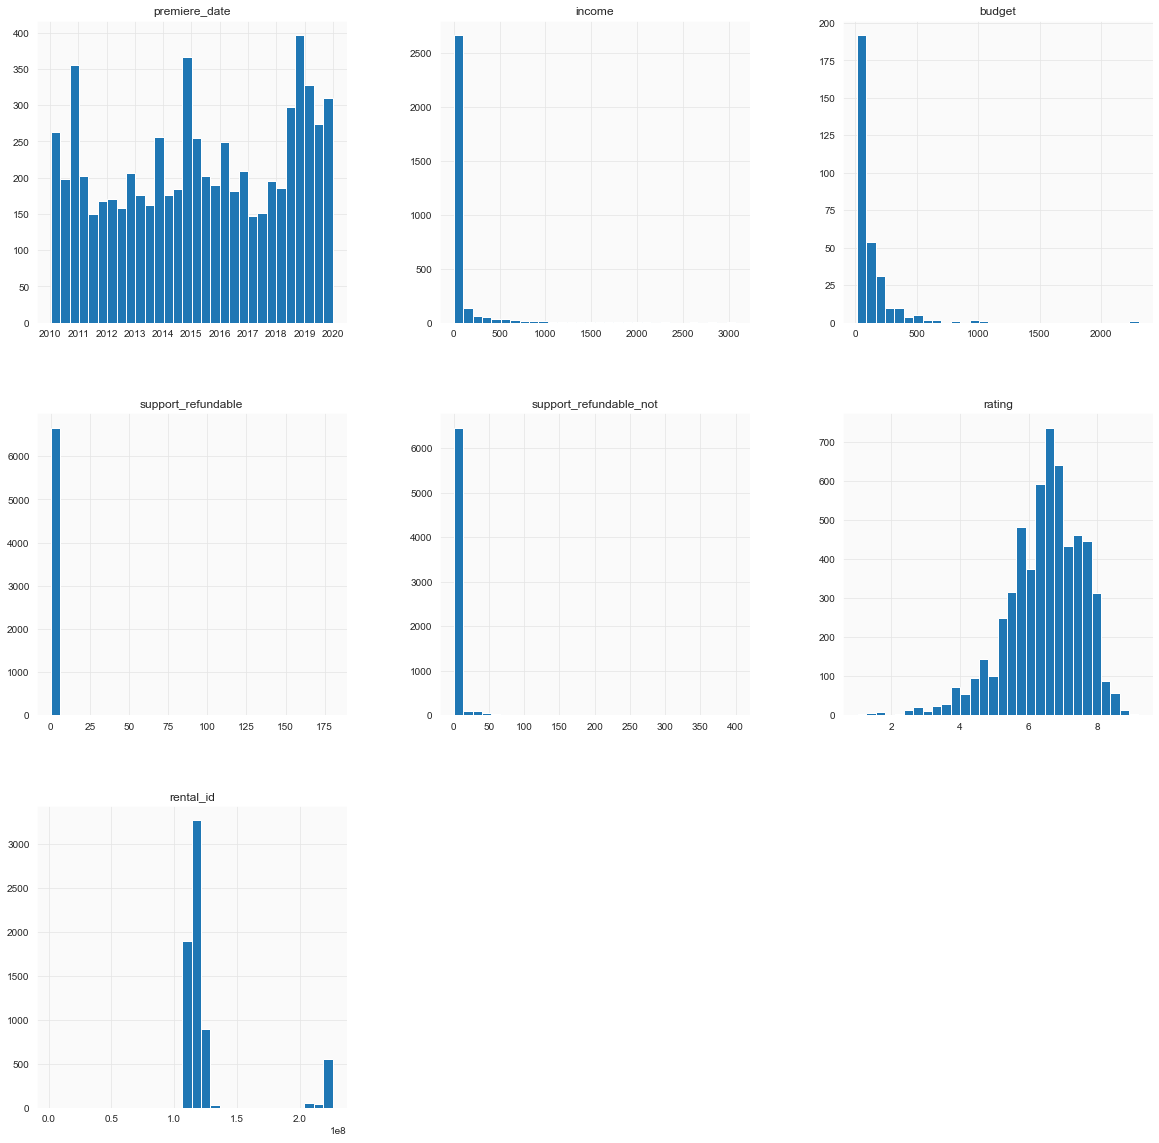

In [48]:
data.hist(bins=30, figsize=(20,20));

> Распределение **raiting** похоже на нормальное со свещением вправо.

> Финансовые поля содержат большое количество нулевых и околонулевых значений. Они требуют более детального изучения.

> В распределении номеров прокатных удостоверений присутствует большой просвет. Предположительно, это связано с какими-либо изменениями в организации, осуществляющей их выдачу.

#### **income** (сборы в кинотеатрах)

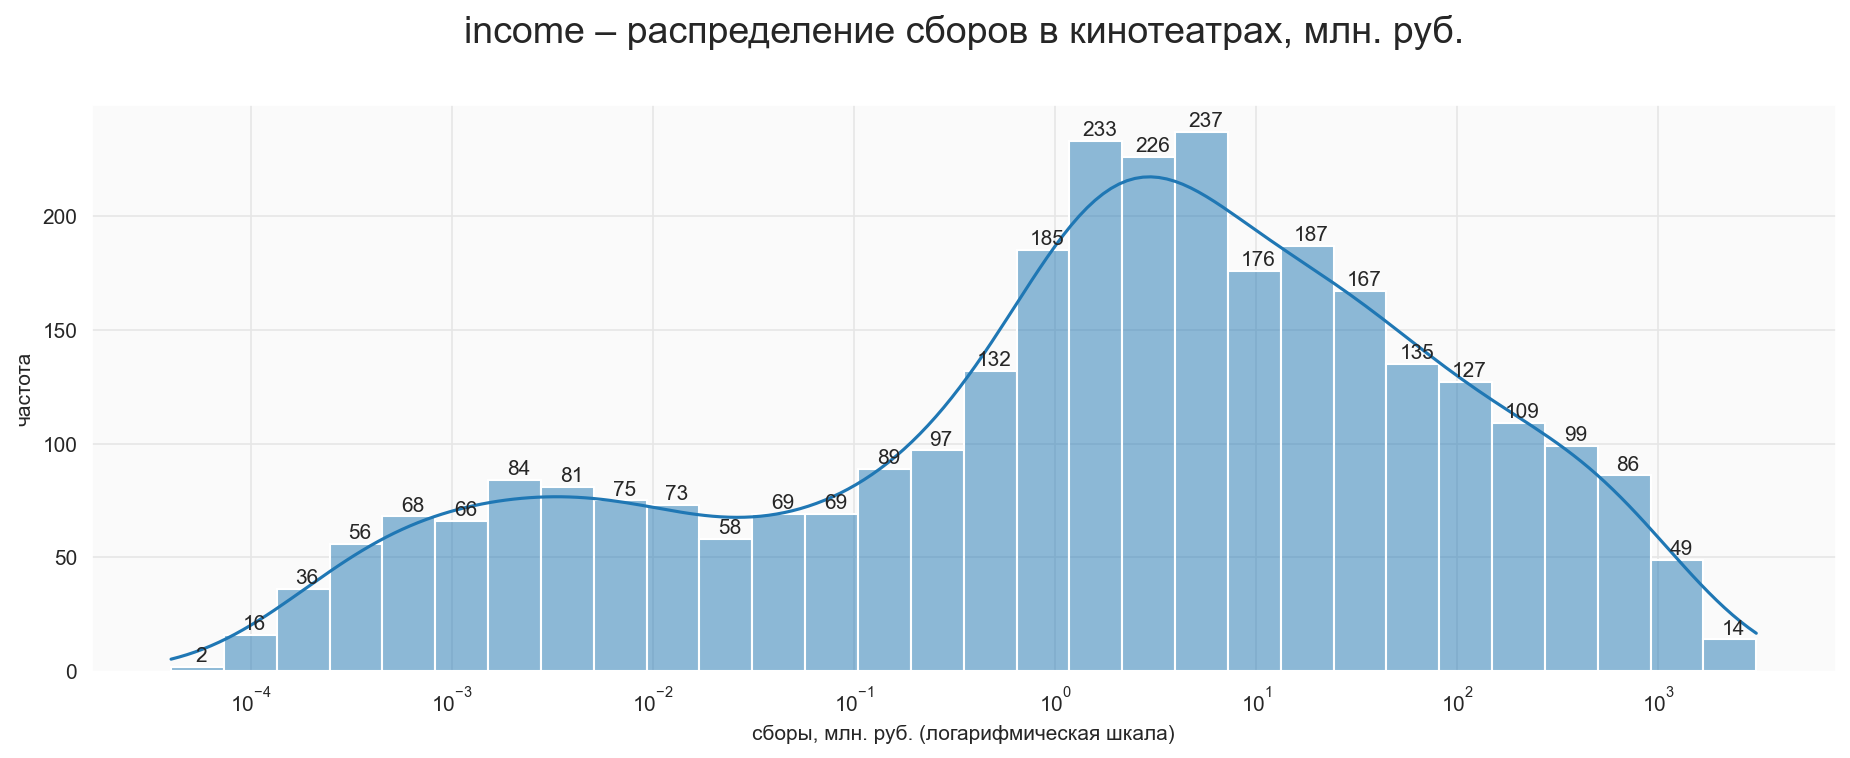

In [49]:
fig, ax = plt.subplots(figsize=(15,5), dpi=plot_dpi)

sns.histplot(
             x=data.income,
             bins=30,
             log_scale=True,
             kde=True,
            )

ax.set_title('income – распределение сборов в кинотеатрах, млн. руб.', size=18, pad=30)
ax.set_ylabel('частота')
ax.set_xlabel('сборы, млн. руб. (логарифмическая шкала)')

bar_annotate(ax)

space()
plt.show()

Диаграмма размаха без ограничения максимального сбора

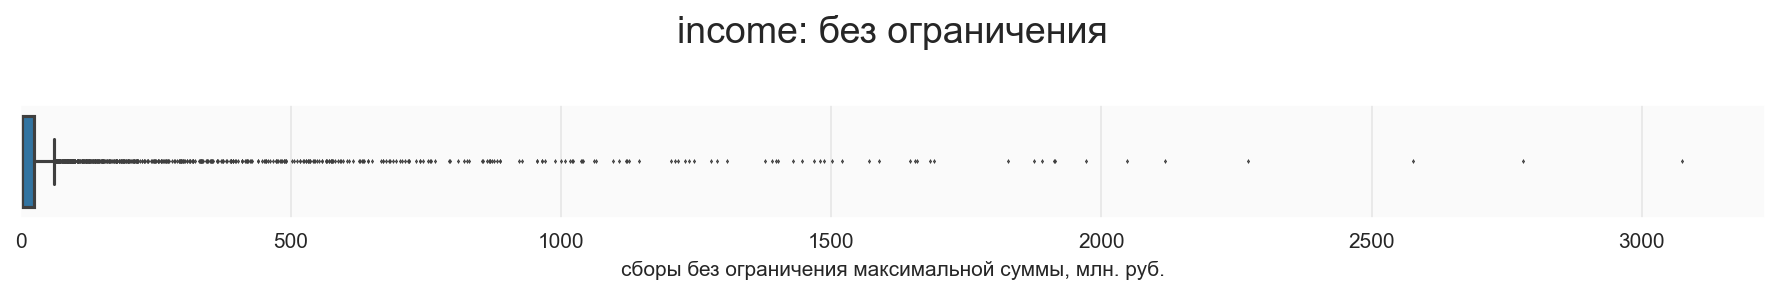

In [50]:
fig, ax = plt.subplots(figsize=(15,1), dpi=plot_dpi)

sns.boxplot(
            x=data.income,
            fliersize=0.3,
           )
ax.set_xlim(0,)
ax.set_title('income: без ограничения', size=18, pad=30)
ax.set_xlabel('сборы без ограничения максимальной суммы, млн. руб.')

space()
plt.show()
space()

Диаграмма размаха c ограничением максимального сбора на 500 млн. руб.

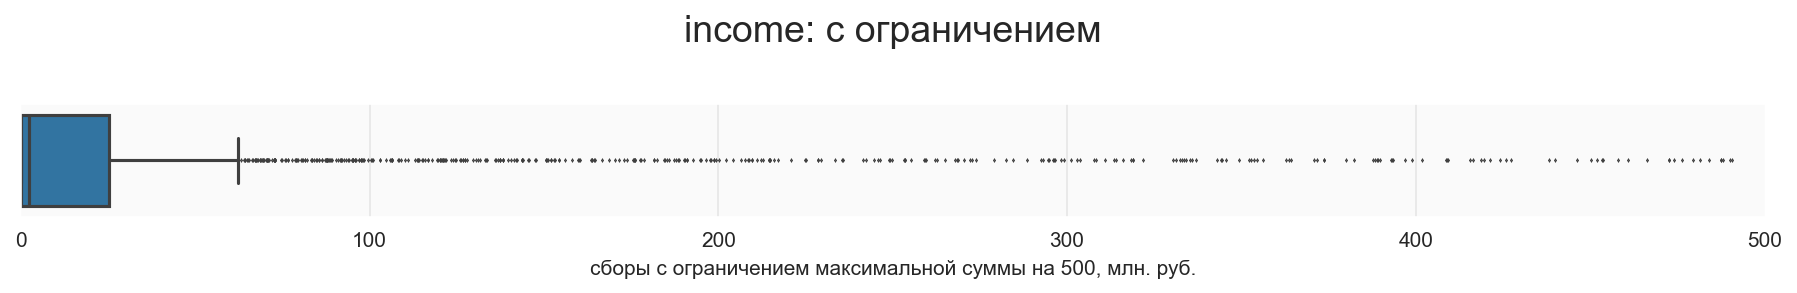

In [51]:
fig, ax = plt.subplots(figsize=(15,1), dpi=plot_dpi)

sns.boxplot(
            x=data.income,
            fliersize=0.3,
           )
ax.set_xlim(0,500)
ax.set_title('income: с ограничением', size=18, pad=30)
ax.set_xlabel('сборы с ограничением максимальной суммы на 500, млн. руб.')

space()
plt.show()
space()

Статистика по полю `income`

In [52]:
data.income.describe().to_frame()

,income
count,3101.000
mean,77.884
std,242.327
min,0.000
25%,0.130
50%,2.488
75%,25.247
max,3073.569


Пример неполноты данных о кассовых сборах

In [53]:
data.query('title == "сталинград"')

,title,director,premiere_date,income,budget,support_refundable,support_refundable_not,support_source,rating,studio,rental_id,type,country,producer,age_rating,genres
5645,сталинград,ф.бондарчук,2013-09-20,0.002,NaN,0.000,0.000,{без господдержки},5.700,"{ооо ""арт пикчерс студия"", ооо ""нон-стоп продакшн""}",111004313,художественный,россия,"{ооо ""арт пикчерс студия"", ооо ""нон-стоп продакшн"", оао ""банк втб"", оао ""телекомпания"", фгуп ""вг...",«12+» - для детей старше 12 лет,"{военный,драма,боевик}"


> Разница в денежных сборах между соседними фильмами растет с увеличением размера сборов. Это означает, что на гистограмме, где размер корзин одинаков, большая часть значений попадает в первые корзины.
>
> Если посмотреть на гистограмму логарифма сборов, то распределение выглядит более показательно.  
> На графике видны две области значений (приблизительно):  
> -- от 100 до 10000 руб.;  
> -- от 1 до 5 млн. руб.
>
> Отличие распределения от нормального (провал в середине) говорит по меньшей мере о том, что представленные фильмы имеют существенные различия, ввиду чего сравнение их сборов напрямую непоказательно.
>
> Возможные варианты появления значений менее 100 тыс. руб.:  
> -- фильмы демонстрировались по альтернативным схемам (фестивальные показы, пакетный показ, и пр.);  
> -- не все сборы учтены в итоговой сумме (см. пример: фильм Бондарчука "Сталинград" заработал целых 2 тысячи рублей);  
> -- некорректный перевод в рубли из других валют;  
> -- некорректно сравнивать рубль СССР и рубль РФ.
>
> Справа наблюдается большое количество выбросов. Возможно, их количество уменьшится после коррекции сверхмалых сборов.


> **Предварительный вывод**  
> Перед использованием данных о денежных сборах, необходимо проверить их корректность. При необходимости ввести в данные условия, при которых были получены эти данные. Еще лучше, если сборы будут рассчитываться по стандартной и открытой методике.

#### **budget** (бюджет)

Гистограмма с логарифмической шкалой без ограничения максимального бюджета

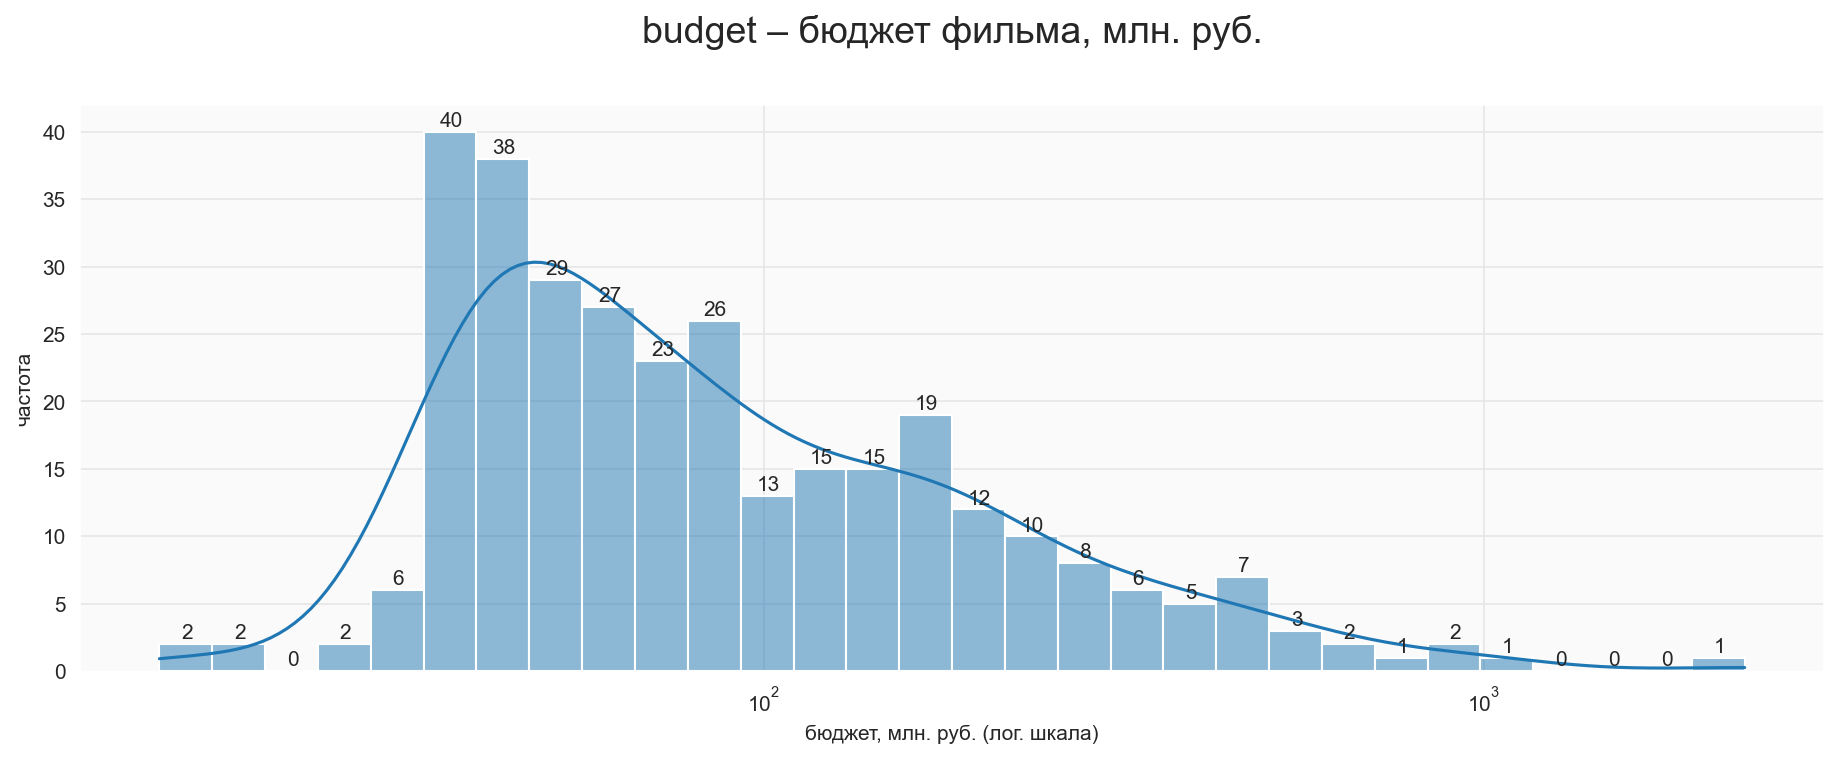

In [54]:
fig, ax = plt.subplots(figsize=(15,5), dpi=plot_dpi)

sns.histplot(
             x=data.budget,
             bins=30,
             log_scale=True,
             kde=True,
            )

ax.set_title('budget – бюджет фильма, млн. руб.', size=18, pad=30)
ax.set_ylabel('частота')
ax.set_xlabel('бюджет, млн. руб. (лог. шкала)')

bar_annotate(ax)

space()
plt.show()
space()

Гистограмма с линейной шкалой и ограничением максимального бюджета на 500 млн. руб.

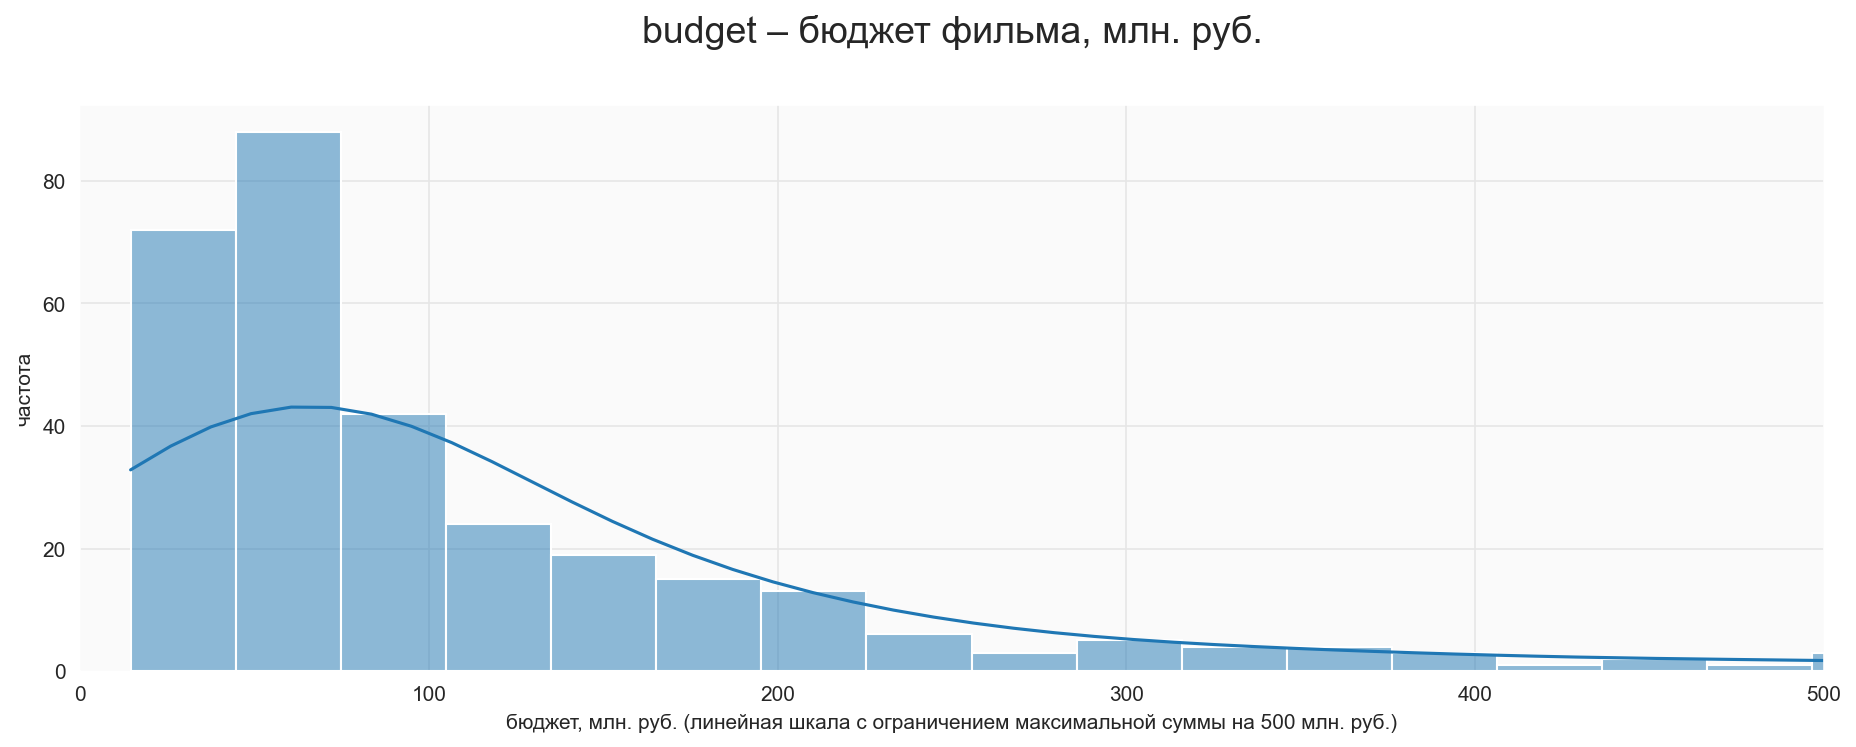

In [55]:
fig, ax = plt.subplots(figsize=(15,5), dpi=plot_dpi)

sns.histplot(
             x=data.budget,
             kde=True,
            )

ax.set_xlim(0, 500)

ax.set_title('budget – бюджет фильма, млн. руб.', size=18, pad=30)
ax.set_ylabel('частота')
ax.set_xlabel('бюджет, млн. руб. (линейная шкала с ограничением максимальной суммы на 500 млн. руб.)')

space()
plt.show()
space()

Диаграмма размаха без ограничения максимального бюджета

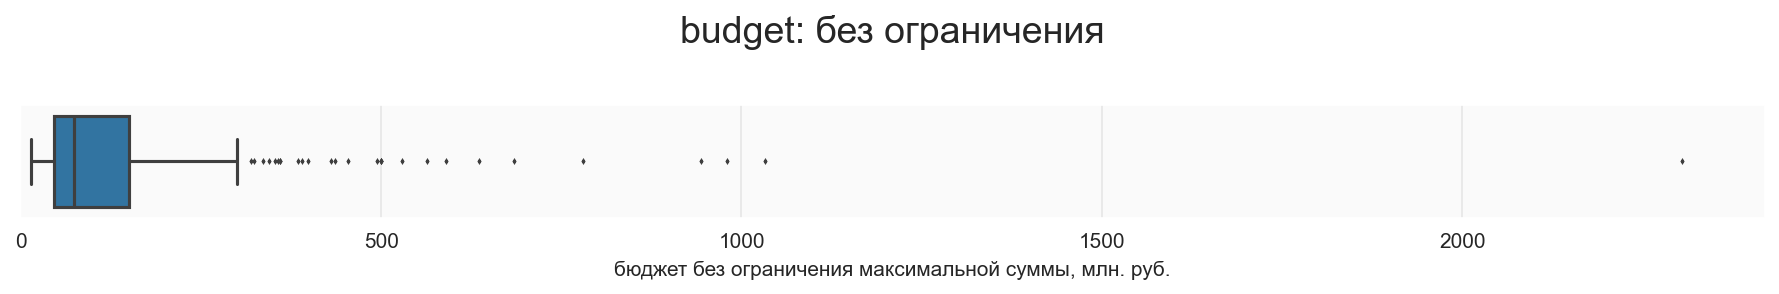

In [56]:
fig, ax = plt.subplots(figsize=(15,1), dpi=plot_dpi)

sns.boxplot(
            x=data.budget,
            fliersize=1.0,
           )
ax.set_xlim(0,)
ax.set_title('budget: без ограничения', size=18, pad=30)
ax.set_xlabel('бюджет без ограничения максимальной суммы, млн. руб.')

space()
plt.show()
space()

Диаграмма размаха с ограничением максимального бюджета на 500 млн. руб.

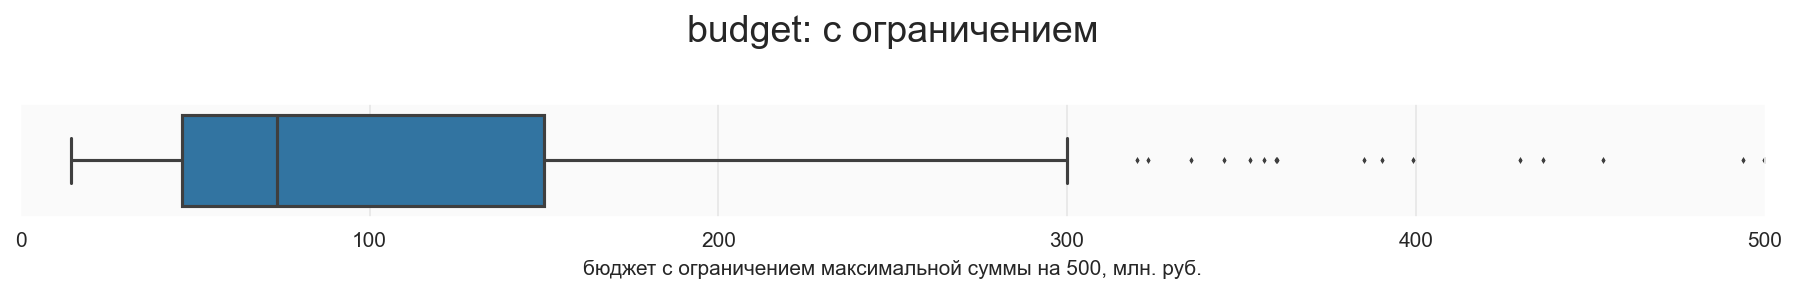

In [57]:
fig, ax = plt.subplots(figsize=(15,1), dpi=plot_dpi)

sns.boxplot(
            x=data.budget,
            fliersize=1.0,
           )
ax.set_xlim(0, 500)
ax.set_title('budget: с ограничением', size=18, pad=30)
ax.set_xlabel('бюджет с ограничением максимальной суммы на 500, млн. руб.')

space()
plt.show()
space()

Статистика по полю `budget`

In [58]:
data.budget.describe().to_frame()

,budget
count,315.000
mean,134.096
std,191.226
min,14.462
25%,46.154
50%,73.380
75%,150.004
max,2305.074


Расчет верхней границы для определения выбросов

In [59]:
data.budget.quantile(0.75) + (data.budget.quantile(0.75) - data.budget.quantile(0.25)) * 1.5

305.7799165

Фильм с самым большим бюджетом

In [60]:
data.query('budget == budget.max()')

,title,director,premiere_date,income,budget,support_refundable,support_refundable_not,support_source,rating,studio,rental_id,type,country,producer,age_rating,genres
5816,тайна печати дракона,о.степченко,2019-09-12,333.597,2305.074,180.000,90.000,{фонд кино},5.800,"{ооо ""кинокомпания ""ств""; ооо ""рфг корп""; ооо ""рфг""; ао ""маринс групп интертеймент""; ооо ""фетисо...",111012819,художественный,россия-китай,"{с.сельянов, а.петрухин}",«6+» - для детей старше 6 лет,"{приключения,фэнтези}"


> Обобщая приведенные графики бюджета, можно отметить очень длинный хвост выбивающихся больших значений, который сам может быть проанализирован на выбросы как отдельный датасет (выбросы среди выбросов ))
>
> Особо можно отметить фильм с самым большим бюджетом, который более чем вдвое превосходит бюджет идущего следом. Удивительно, но режиссер не тот, на кого все подумали.
>
> В зависимости от целей для дальнейшего использования поле **budget** может понадобиться очистить от выбросов.

<a id="id_support"></a>
#### **support_refundable** и **support_refundable_not** (господдержка)

Гистограмма возвратных средств господдержки, исключая фильмы без господдержки

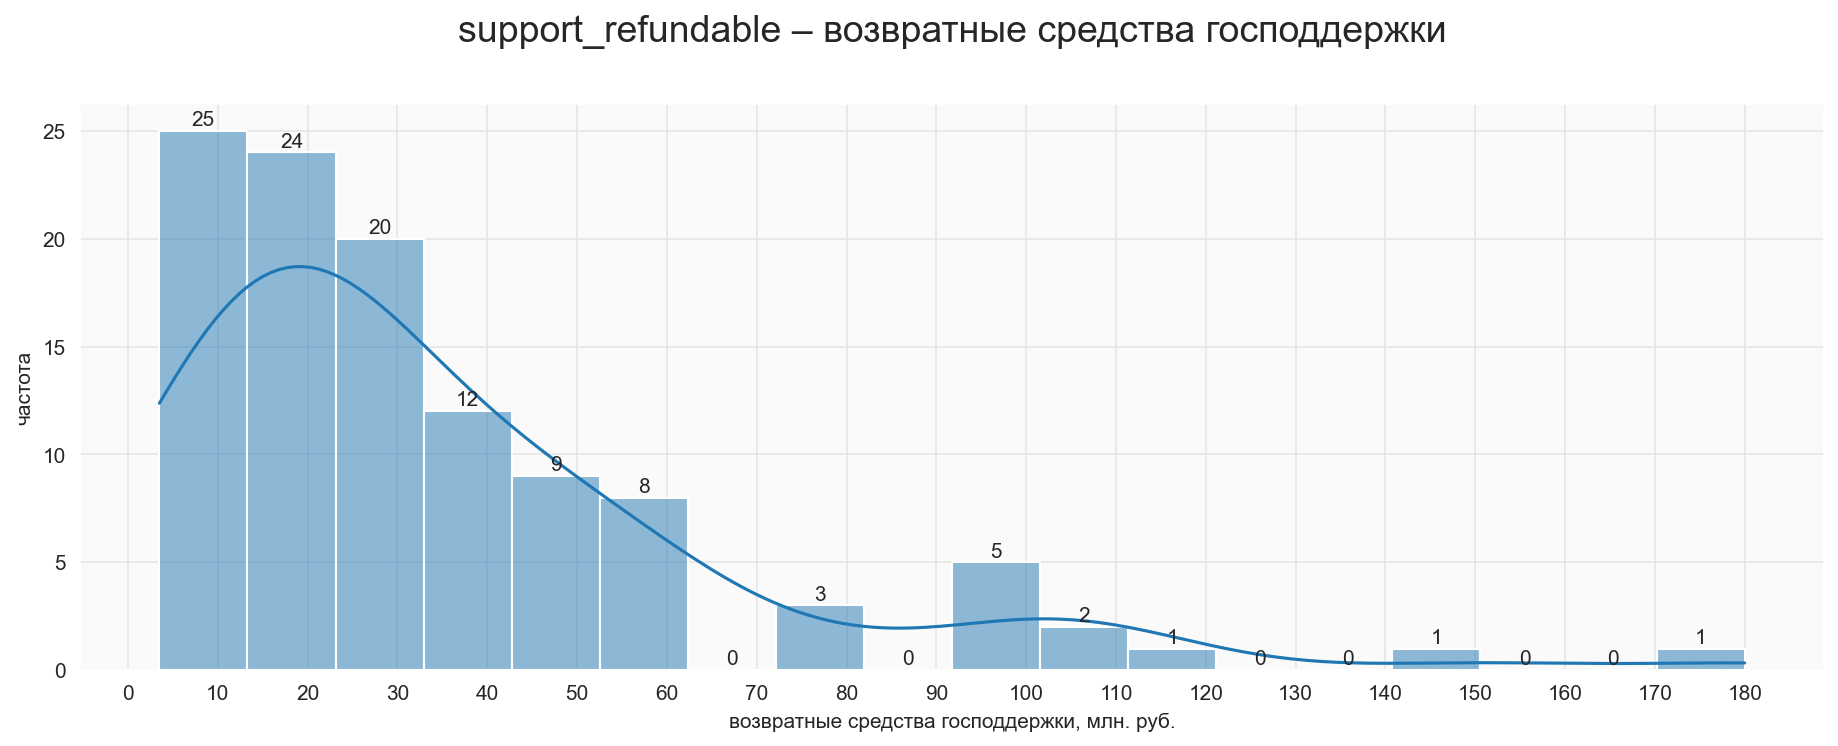

In [61]:
fig, ax = plt.subplots(figsize=(15,5), dpi=plot_dpi)

sns.histplot(
             x=data.query('support_refundable > 0').support_refundable,
             bins=18,
             kde=True,
            )

ax.set_title('support_refundable – возвратные средства господдержки', size=18, pad=30)
ax.set_ylabel('частота')
ax.set_xlabel('возвратные средства господдержки, млн. руб.')

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))

bar_annotate(ax)

space()
plt.show()
space()

Гистограмма **не**возвратных средст господдержки, исключая фильмы без господдержки

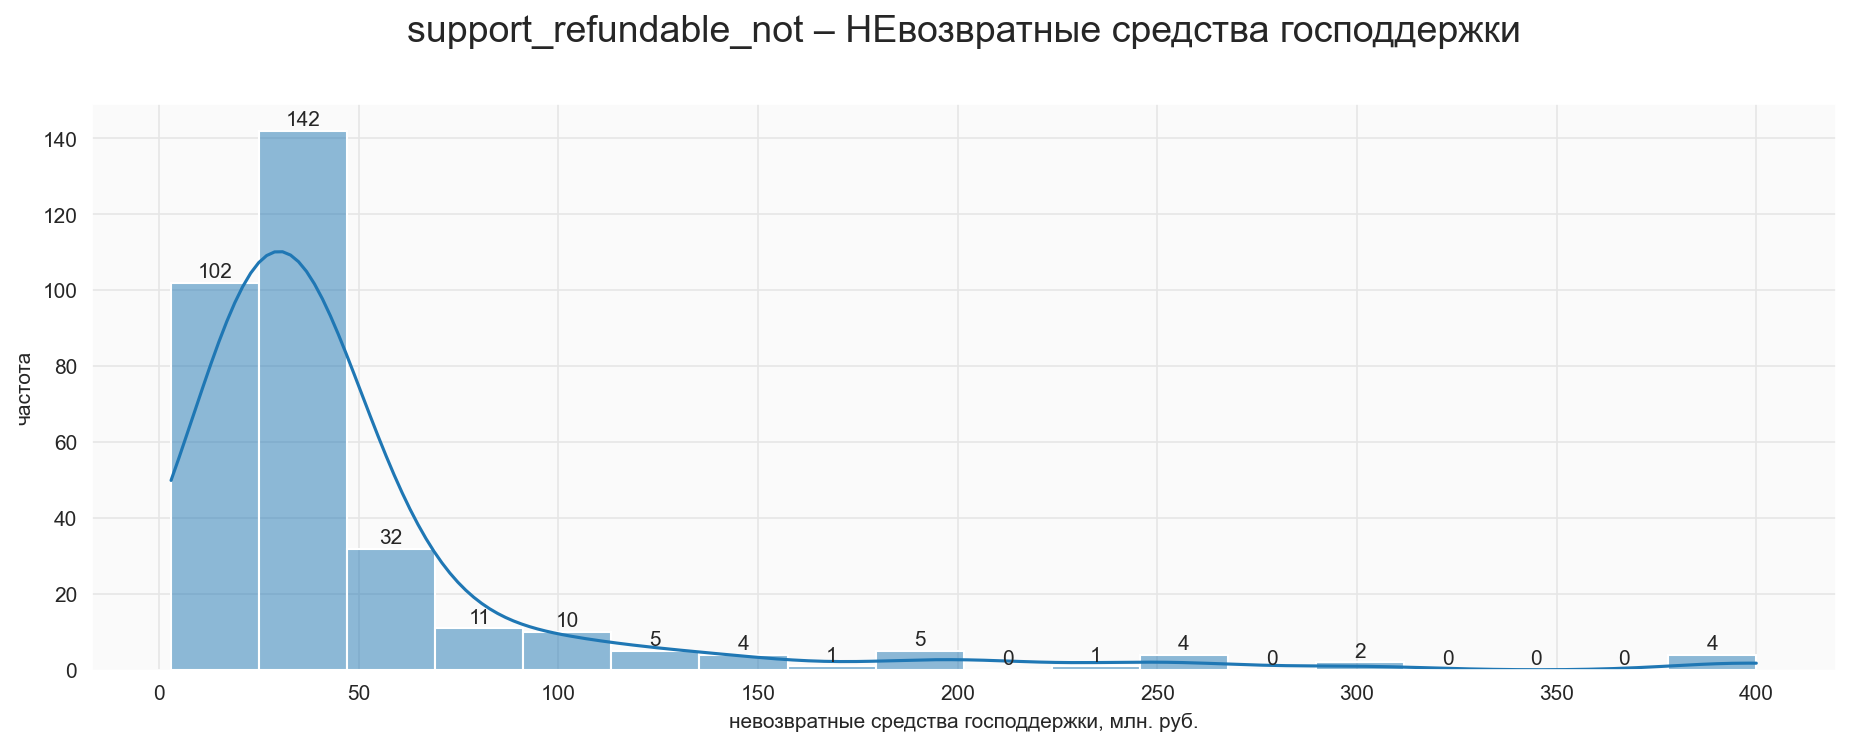

In [62]:
fig, ax = plt.subplots(figsize=(15,5), dpi=plot_dpi)

sns.histplot(
             x=data.query('support_refundable_not > 0').support_refundable_not,
             bins=18,
             kde=True,
            )

ax.set_title('support_refundable_not – НЕвозвратные средства господдержки', size=18, pad=30)
ax.set_ylabel('частота')
ax.set_xlabel('невозвратные средства господдержки, млн. руб.')

bar_annotate(ax)

space()
plt.show()
space()

Статистика господдержки

In [63]:
data.query('support_refundable > 0').support_refundable.describe().to_frame()

,support_refundable
count,111.000
mean,35.486
std,31.973
min,3.500
25%,15.000
50%,25.000
75%,50.000
max,180.000


In [64]:
data.query('support_refundable_not > 0').support_refundable_not.describe().to_frame()

,support_refundable_not
count,323.000
mean,50.346
std,60.243
min,3.000
25%,25.000
50%,30.000
75%,45.000
max,400.000


Суммарный бюджет фильма должен быть не меньше суммарной господдержки фильма.

In [65]:
(
 data
 .assign(budget_filled = lambda df: df.budget.fillna(0))                      # в поле budget есть пропуски
 .query('budget_filled < (support_refundable + support_refundable_not)')
 [['budget','budget_filled','support_refundable','support_refundable_not']]
)

,budget,budget_filled,support_refundable,support_refundable_not
48,NaN,0.000,0.000,23.000
450,NaN,0.000,0.000,138.969
490,NaN,0.000,20.000,0.000
686,NaN,0.000,60.000,120.000
1002,NaN,0.000,10.000,70.000
1426,NaN,0.000,10.000,60.000
1808,NaN,0.000,0.000,75.000
3053,NaN,0.000,19.000,51.000
3373,NaN,0.000,25.000,20.000
4626,NaN,0.000,0.000,6.000


> Для распределений возвратной и невозвратной господдержки характерны длинные хвосты высоких значений.
>
> Невозвратная поддержка оказывалась примерно втрое чаще и по параметрам (среднее, медиана, максимум) была щедрее возвратной.
>
> Есть 17 фильмов, для которых при наличии господдержки не указан бюджет. Это может повлиять на результат дальнейшего анализа.
>
> Несколько фильмов получили господдержку в очень большом размере. Они могли бы стать темой для отдельного исследования.

#### **rating** (пользовательский рейтинг в "Кинопоиске")

Гистограмма рейтинга

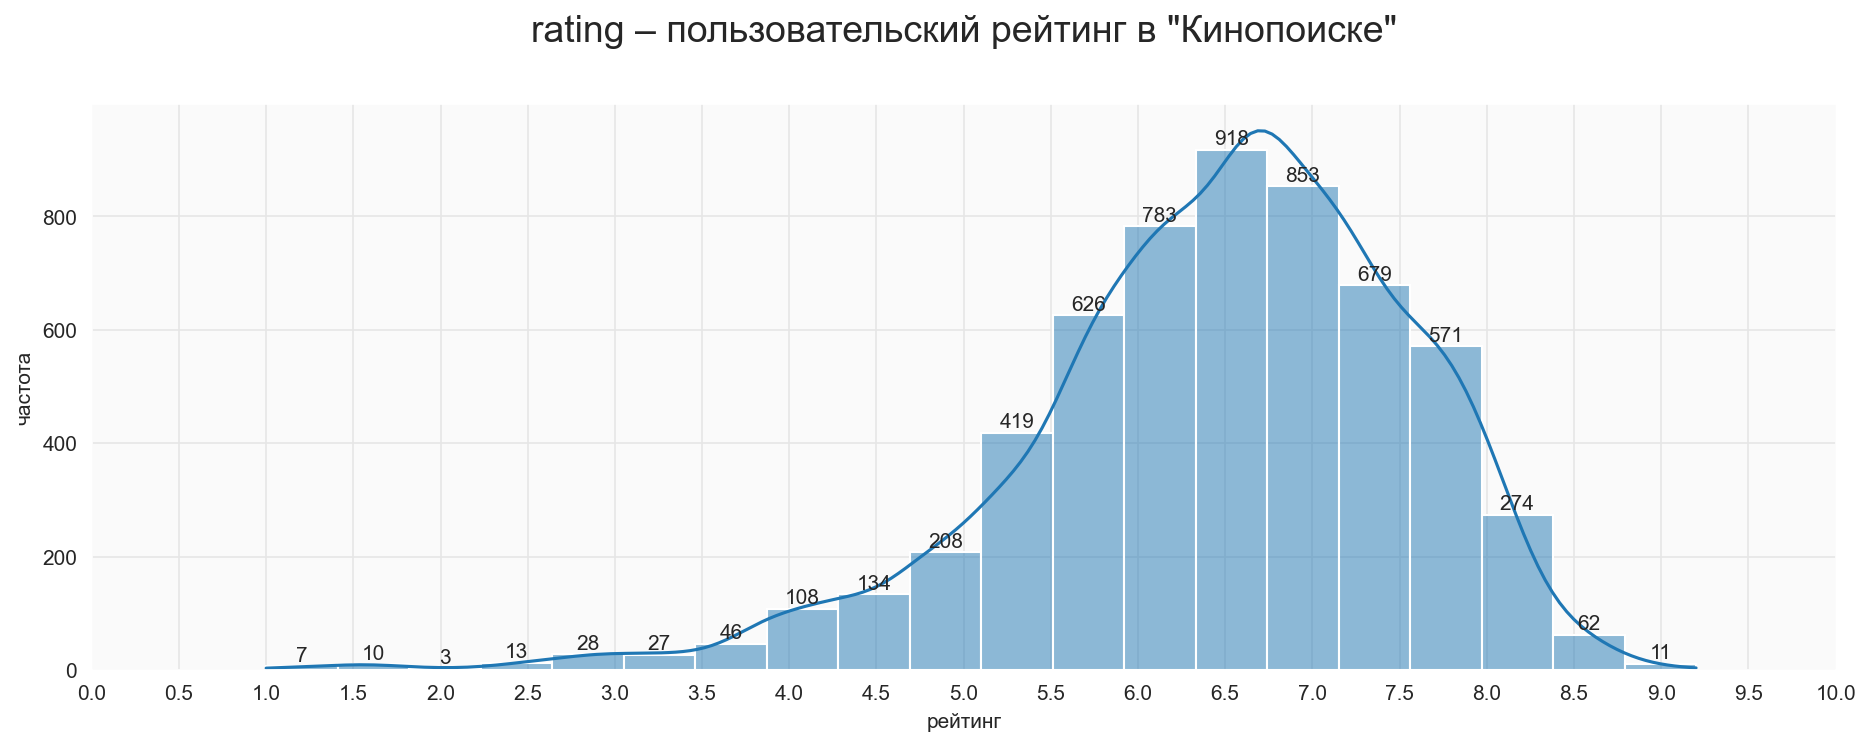

In [66]:
fig, ax = plt.subplots(figsize=(15,5), dpi=plot_dpi)

sns.histplot(
             x=data.rating,
             bins=20,
             kde=True,
            )

ax.set_title('rating – пользовательский рейтинг в "Кинопоиске"', size=18, pad=30)
ax.set_ylabel('частота')
ax.set_xlabel('рейтинг')
ax.set_xlim(0,10)

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.5))

bar_annotate(ax)

space()
plt.show()

Диаграмма разброса рейтинга

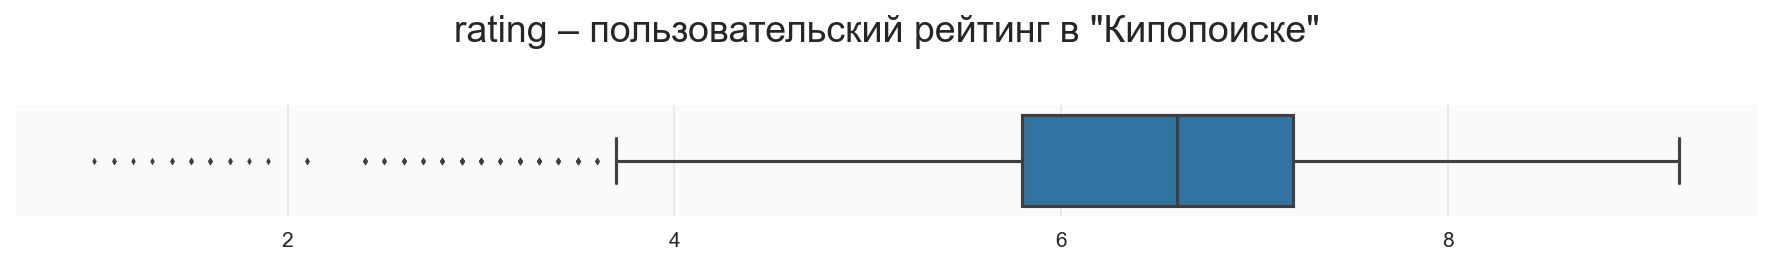

In [67]:
fig, ax = plt.subplots(figsize=(15,1), dpi=plot_dpi)

sns.boxplot(
            x=data.rating,
            fliersize=1.2,
           )
ax.set_title('rating – пользовательский рейтинг в "Кипопоиске"', size=18, pad=30)
ax.set_xlabel('')

space()
plt.show()
space()

> Распределение значений рейтинга похоже на нормальное с некоторым смещением вправо.
>
> Возможно, стоит отнестись с сомнением к значениям рейтинга до 3, поскольку известны случаи целенаправленного понижения со стороны зрителей.

### Добавление новых полей

Год премьеры

In [68]:
data['premiere_year'] = data.premiere_date.dt.year.astype('int16')

Главный режиссер

In [69]:
data['director_main'] = data.director.str.split(',').str[0]

Главный жанр

In [70]:
data['genre_main'] = (
                      data
                      .genres
                      .apply(repr)              # преобразование из set в str
                      .str.replace('{','')
                      .str.replace('}','')
                      .str.replace('\'','')
                      .str.replace('\"','')
                      .str.replace('nan','')
                      .str.split(',')
                      .str[0]
                     )

Доля господдержки

In [71]:
data['support_part'] = ((data.support_refundable + data.support_refundable_not) / data.budget)#.fillna(0)

Проверка результата создания новых полей

In [72]:
data.query('director.str.contains(",")')[['premiere_date','premiere_year','director','director_main','genres','genre_main']].sample(5)

,premiere_date,premiere_year,director,director_main,genres,genre_main
4957,2011-05-25,2011,"бени бернхардт, луиз а.гиков",бени бернхардт,"{фантастика,триллер,драма}",фантастика
5279,2016-04-29,2016,"у.бош, м.данкер, л.индовина, к.кэхилл, р.люкер, б.магнотье, э.маргетсон, т.эльрих",у.бош,"{мультфильм,фантастика,фэнтези}",мультфильм
12,2018-10-08,2018,"д.кузнецов (псевдоним - хаски), д.найшуллер (псевдоним - даша чаруша), с.поварницын, а.золотарев...",д.кузнецов (псевдоним - хаски),"{драма,комедия}",драма
3460,2012-08-13,2012,"джейми брэдшоу, александр дулерайн",джейми брэдшоу,"{фантастика,триллер}",фантастика
942,2018-04-05,2018,"майкл спириг, питер спириг",майкл спириг,"{ужасы,фэнтези,детектив}",ужасы


In [73]:
data.query('support_refundable_not > 0')[['support_refundable','support_refundable_not','budget','support_part']].sample(5)

,support_refundable,support_refundable_not,budget,support_part
2655,30.000,35.000,169.000,0.385
6685,0.000,25.000,38.000,0.658
5394,0.000,40.000,64.793,0.617
5991,0.000,260.000,390.191,0.666
2657,10.000,24.450,58.078,0.593


> Для фильмов, у которых не указан бюджет, но присутствует господдержка, невозможно корректно рассчитать долю господдержки. Поле `support_part` будет содержать `NaN`.

> Фильмы, для которых не указан ни один из жанров будут содержать в поле `genre_main` пустую строку.

## Исследовательский анализ данных

<a id="id_premier_annualy"></a>
### Количество премьер в год

Будет исследовано количество премьер в год, в том числе с указанной информацией о прокате в кинотеатрах (другими словами, с указанной суммой сборов).

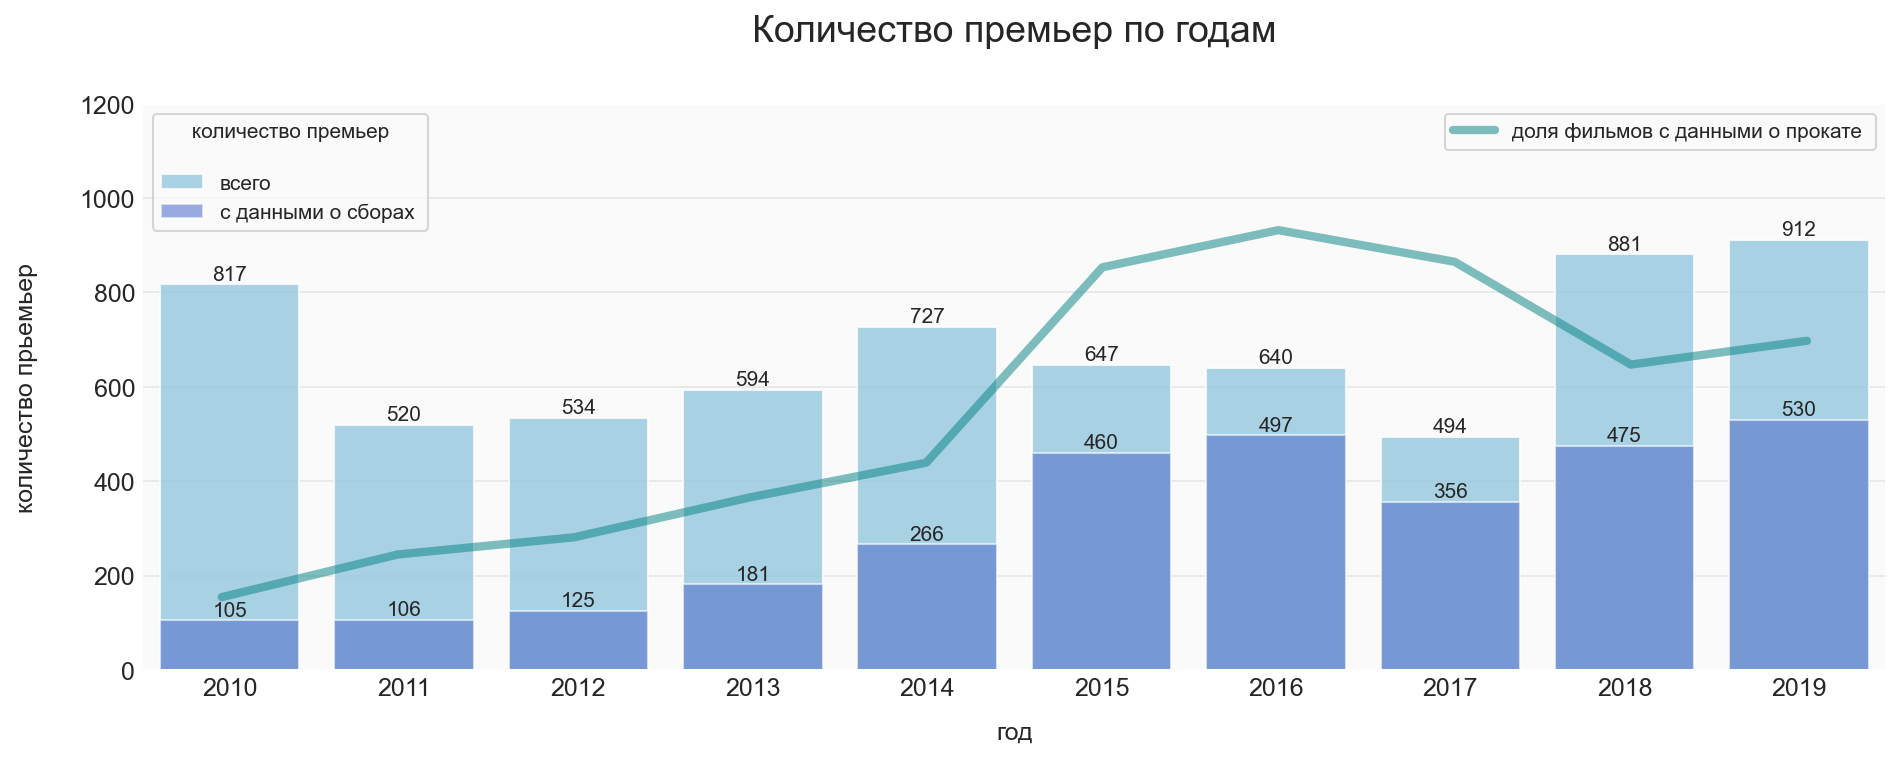

,premiere_year,total,has_income,has_income_part
0,2010,817,105,13%
1,2011,520,106,20%
2,2012,534,125,23%
3,2013,594,181,30%
4,2014,727,266,37%
5,2015,647,460,71%
6,2016,640,497,78%
7,2017,494,356,72%
8,2018,881,475,54%
9,2019,912,530,58%


In [74]:
fig, ax = plt.subplots(figsize=(15,5), dpi=plot_dpi)


# график: количество всех фильмов
sns.countplot(
              x=data.premiere_year,
              color='skyblue',
              alpha=0.8,
             )


# график: количество фильмов с известной суммой сборов в прокате
sns.countplot(
              x=data.query('income > 0').premiere_year,
              color='royalblue',
              alpha=0.6,
             )


# график: доля фильмов с известной суммой сборов в прокате

ax2 = ax.twiny()  # проще, конечно, через twinx(), но помешал непонятный глюк

df = (
      data
      .groupby('premiere_year')
      .agg(total=('title','count'), has_income=('income','count'))
      .reset_index()
      .assign(has_income_part = lambda df: df.has_income / df.total)
     )

sns.lineplot(
             x=df.premiere_year,
             y=df.has_income_part*1200,
             color='teal',
             linewidth=4,
             alpha=0.5,
             ax=ax2,
            )


# тюнинг графиков

ax.set_ylim(0,1200)
ax.set_title('Количество премьер по годам', size=18, pad=30)
ax.set_xlabel('год', size=12, labelpad=10)
ax.set_ylabel('количество прьемьер', size=12, labelpad=20)
ax.tick_params(labelsize=12, length=0)
ax.legend(['всего', 'с данными о сборах '], title=' количество премьер \n', loc='upper left', fontsize=10, title_fontsize=10)

ax2.xaxis.set_major_locator(ticker.NullLocator())
ax2.set_xlabel('')
ax2.grid(False)
ax2.legend(['доля фильмов с данными о прокате '], title='', loc='upper right', fontsize=10, title_fontsize=10)

bar_annotate(ax)


space()
plt.show()


# таблица

df.style.format('{:.0%}',subset='has_income_part')

> Общее количество премьер в 2015-2017 годах шло на спад, затем тенденция к росту вернулась.
>
> Доля фильмов с данными о прокате постоянно растет, лишь в в конце периода отмечается ее снижение. Возможная причина: снижение популярности кинотеатров и рост доли фильмов, не использующих традиционный прокат.
>
> В 2015 году виден резкий рост доли фильмов с данными о прокате. 2015-2017 годы выглядят аномальным всплеском. Возможно, это объясняется нехваткой каких-либо данных.

<a id="id_income_annualy"></a>
### Динамика проката по годам

Будет исследована сумма сборов от проката в кинотеатрах

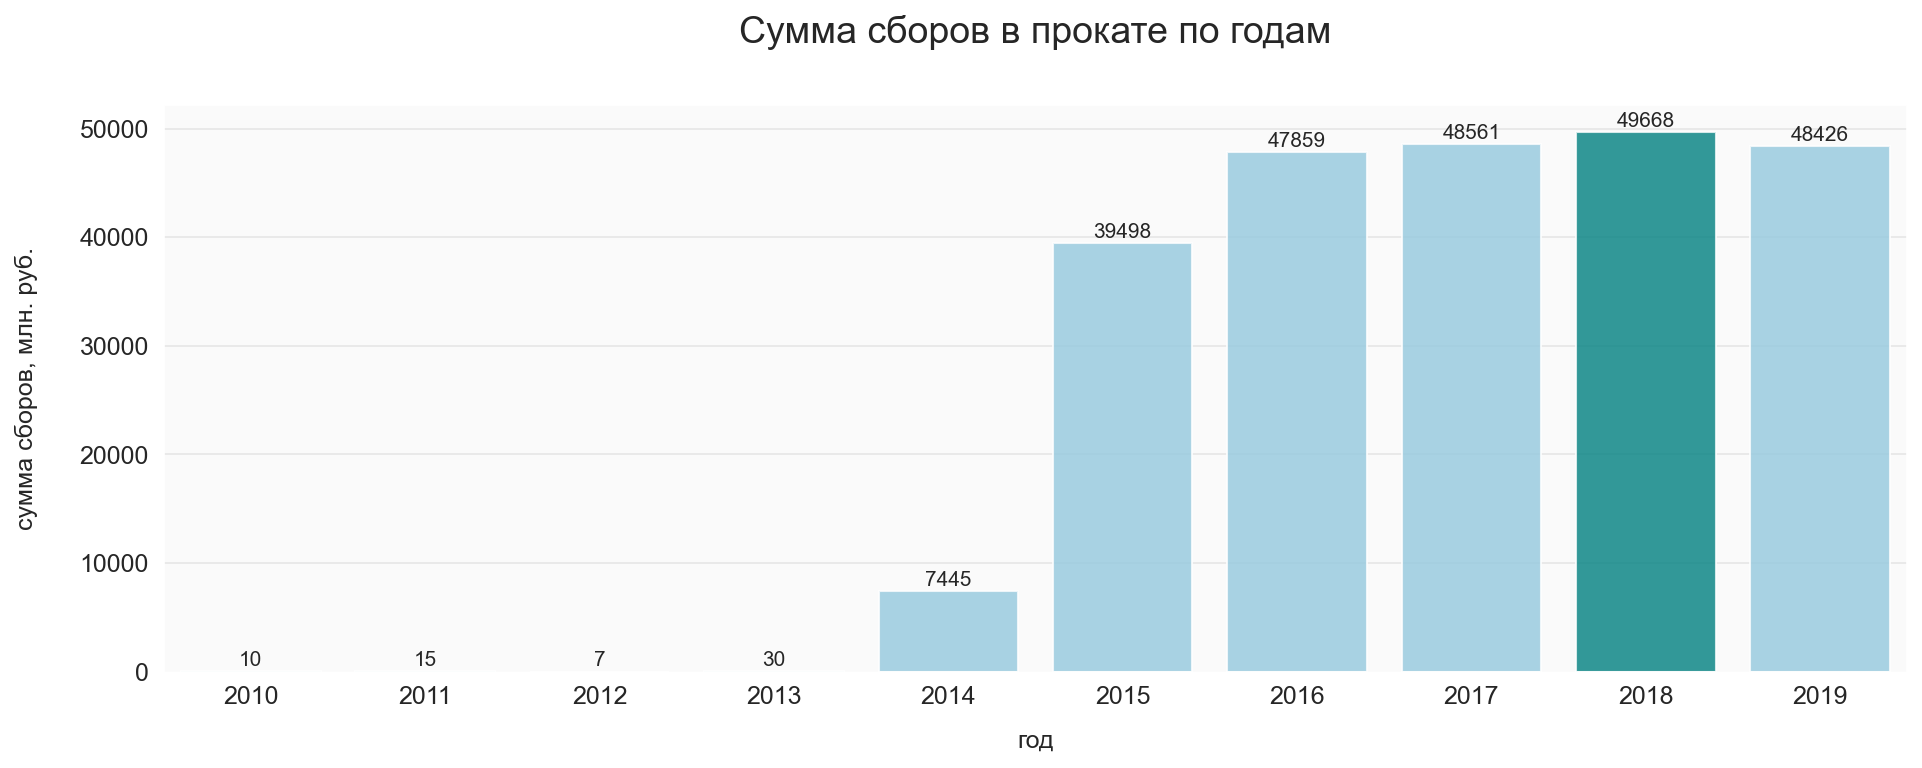

In [75]:
fig, ax = plt.subplots(figsize=(15,5), dpi=plot_dpi)


# подготовка данных

df = (
      data
      .groupby('premiere_year')
      .agg(income_total=('income','sum'))
      .reset_index()
     )


# график

sns.barplot(
            data=df,
            x='premiere_year',
            y='income_total',
            color='skyblue',
            alpha=0.8,
           )


# тюнинг графика

ax.set_title('Сумма сборов в прокате по годам', size=18, pad=30)
ax.set_xlabel('год', size=12, labelpad=10)
ax.set_ylabel('сумма сборов, млн. руб.', size=12, labelpad=20)
ax.tick_params(labelsize=12)

bar_annotate(ax)

for patch in ax.patches:
    if patch.get_height() == df.income_total.min() or patch.get_height() == df.income_total.max():
        patch.set_facecolor('teal')

space()
plt.show()

Тот же график, но с логарифмической шкалой по оси Y (чтобы получше разглядеть малые значения)

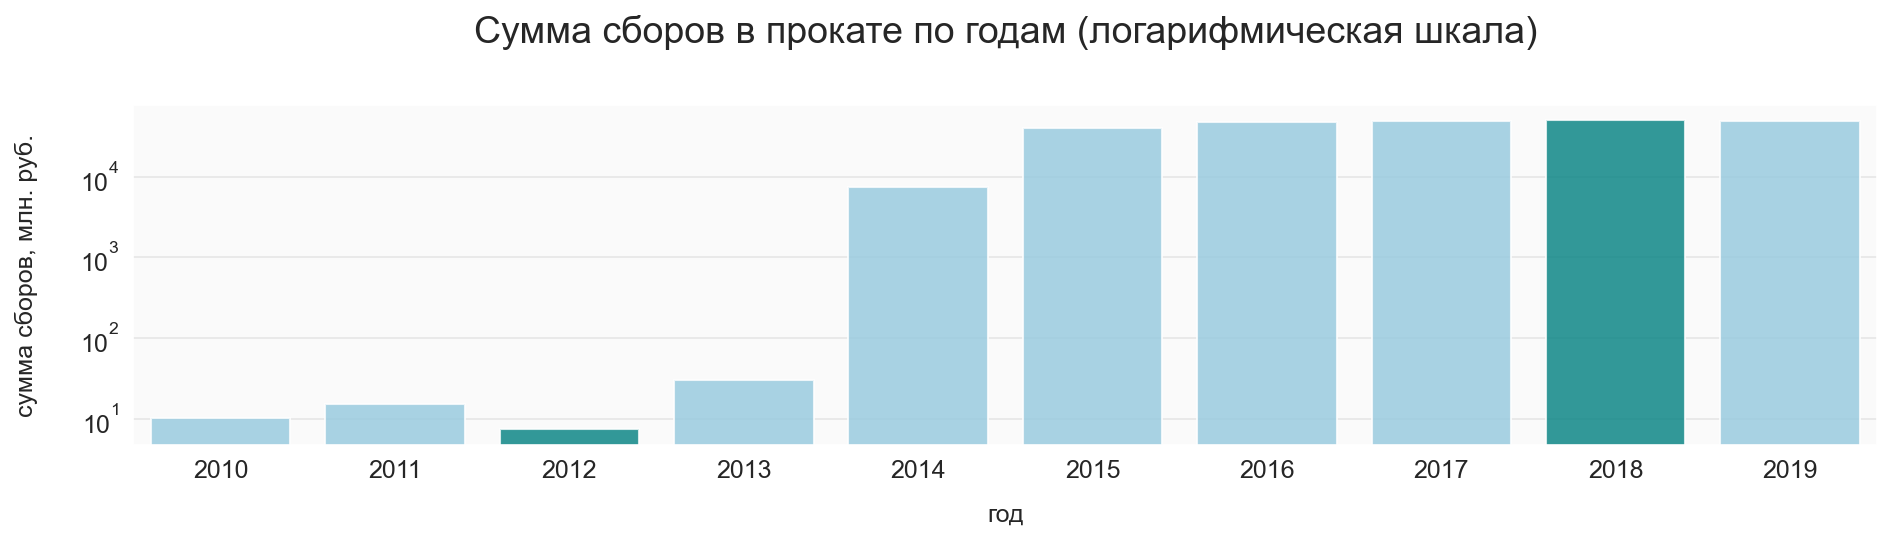

In [76]:
fig, ax = plt.subplots(figsize=(15,3), dpi=plot_dpi)


# график

sns.barplot(
            data=df,
            x='premiere_year',
            y='income_total',
            color='skyblue',
            alpha=0.8,
            log=True,
           )


# тюнинг графика

ax.set_title('Сумма сборов в прокате по годам (логарифмическая шкала)', size=18, pad=30)
ax.set_xlabel('год', size=12, labelpad=10)
ax.set_ylabel('сумма сборов, млн. руб.', size=12, labelpad=20)
ax.tick_params(labelsize=12)

for patch in ax.patches:
    if patch.get_height() == df.income_total.min() or patch.get_height() == df.income_total.max():
        patch.set_facecolor('teal')

space()
plt.show()

> В 2010–2014 годах суммы сборов были относительно небольшими. Вероятно, данные за эти годы являются неполными.
>
> Начиная с конца 2014 года ситуация изменилась: прокатные сборы резко пошли в рост и в дальнейшем, 2016–2019 годы, оставались стабильными. Они еще не знали, что их ждет.
>
> Наибольшие сборы были в 2018 году: 49668 млн. руб.  
> Наиболее слабый – 2012 год: 7 млн. руб. (что, конечно же, совсем непохоже на истину).

### Средняя и медианная сумма сборов для каждого года

Учитываются только те фильмы, для которых прокатные сборы больше нуля

In [77]:
data.pivot_table(index='premiere_year', values='income', aggfunc=['mean','median']).T

,premiere_year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
mean,income,0.098,0.146,0.060,0.165,27.989,85.864,96.295,136.408,104.565,91.369
median,income,0.002,0.003,0.006,0.004,0.024,5.105,4.747,10.178,8.891,4.628


> Медианные сборы за любой год многократно ниже средних.

> Выделяются два периода: 2010–2013 и 2015–2019 годы, а также переходный 2014 год.

> В 2015–2019 годах сначала идет рост средних сборов, достигается максимум в середине периода, затем происходит спад. Медианные сборы почти повторяют динамику средних.

<a id="id_age_rating_annualy"></a>
### Влияние возрастного ограничения аудитории

Оценим значения в поле `age_rating` (возрастное ограничение аудитории)

In [78]:
data.value_counts('age_rating')

age_rating
«16+» - для детей старше 16 лет           2508
«12+» - для детей старше 12 лет           1485
«18+» - запрещено для детей               1432
«0+» - для любой зрительской аудитории     737
«6+» - для детей старше 6 лет              604
dtype: int64

Заменим длинные обозначения на более компактные.  
Одновременно получим бонус: упорядочение по алфавиту совпадает с упорядочением по возрастному ограничению.

In [79]:
data.age_rating = data.age_rating.replace(list(data.age_rating.unique()), ['C_12+','D_16+','B_6+','A_0+','E_18+'])

In [80]:
data.value_counts('age_rating')

age_rating
D_16+    2508
C_12+    1485
E_18+    1432
A_0+      737
B_6+      604
dtype: int64

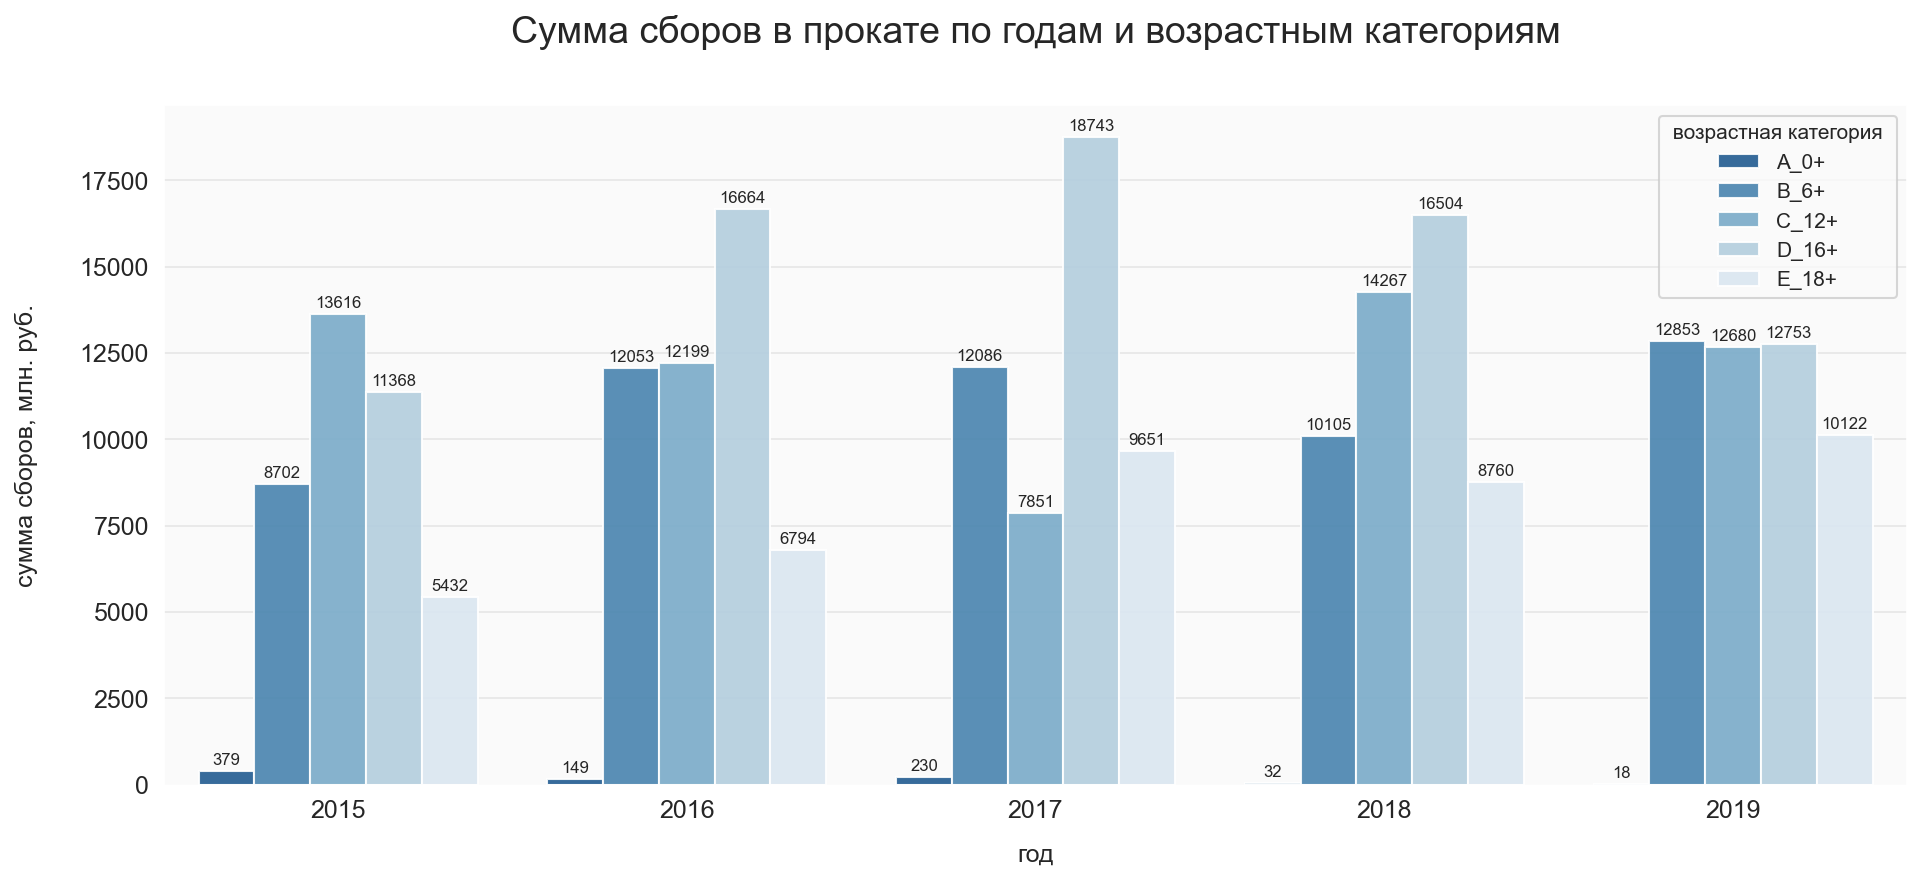

premiere_year,2015,2016,2017,2018,2019,All
age_rating,,,,,,
A_0+,379.054708,148.841710,229.598930,32.449002,17.746067,807.690417
B_6+,8701.799571,12053.143608,12086.142146,10104.974623,12852.548651,55798.608600
C_12+,13616.082009,12199.395012,7851.427661,14267.291661,12680.198774,60614.395116
D_16+,11368.282379,16663.523891,18742.520726,16503.602347,12753.418985,76031.348328
E_18+,5432.309567,6793.923429,9651.495581,8760.085501,10121.796304,40759.610382


In [81]:
fig, ax = plt.subplots(figsize=(15,6), dpi=plot_dpi)


# подготовка данных

df = (
      data
      .query('premiere_year >= 2015')
      .groupby(['premiere_year','age_rating'])
      .agg(income_total=('income','sum'))
      .reset_index()
      .sort_values(['premiere_year','age_rating'])
     )


# график

sns.barplot(
            data=df,
            x='premiere_year',
            y='income_total',
            hue='age_rating',
            palette='Blues_r',
            alpha=0.9,
           )


# тюнинг графика

ax.set_title('Сумма сборов в прокате по годам и возрастным категориям', size=18, pad=30)
ax.set_xlabel('год', size=12, labelpad=10)
ax.set_ylabel('сумма сборов, млн. руб.', size=12, labelpad=20)
ax.tick_params(labelsize=12)
ax.legend(title=' возрастная категория ', loc='upper right', fontsize=10, title_fontsize=10)

bar_annotate(ax, font_size=8)


space()
plt.show()


# таблица

(
 data
 .query('premiere_year >= 2015')
 .pivot_table(index='age_rating', columns='premiere_year', values='income', aggfunc='sum', margins=True)
 .head(-1)
 .style.highlight_max(color='lightgrey', axis=1, subset='All')
 .highlight_max(color='skyblue', subset='All')
)

> За период с 2015 по 2019 год наибольшая сумма прокатных сборов в возрастной категории **"16+"**. Эта категория была самой популярной на протяжении большей части исследуемого периода.
>
> Сборы в категории **"0+"** мизерны на фоне других категорий и к концу исследуемого периода падают до едва различимых.
>
> В последнем году исследуемого периода все категории за исключением **"0+"** идут почти вровень. Однако, нельзя утверждать, что это – новая тенденция. Такое совпадение может быть случайным.

> Зависимость сборов от возрастной категории:  
> - **0**: сборы исчезающе малы по сравнению с другими категорями и с течением времени тенденция усиливается;
> - **16+**: была наиболее популярна в 2016-2018 годы, но, возможно, эта тенденция закончилась;
> - **18+**: как правило, отстает от других категорий (не считая **0+**), но с течением времени отставание сокращается.

> Возможные причины выявленных тенденций:  
> - необходимо искать в правилах присвоения рейтинга (возможно, они слишком строгие или невыгодные для заявителя);
> - вкусы/потребности потребителя изменились.

<a id="id_support"></a>
## Фильмы с господдержкой

> Ранее был проведен [предварительный анализ](#id_support) господдержки.  
>
> Для распределений количества фильмов как с возвратной, так и невозвратной господдержкой характерны длинные хвосты высоких значений. Невозвратная поддержка оказывалась примерно втрое чаще.
>
> Для 17 фильмов, имевших господдержку, не указан общий бюджет. Это неибежно повлияет на результат исследования.

Новое поле: общая сумма господдержки

In [82]:
data['support_total'] = data.support_refundable + data.support_refundable_not

### Суммы господдержки по годам

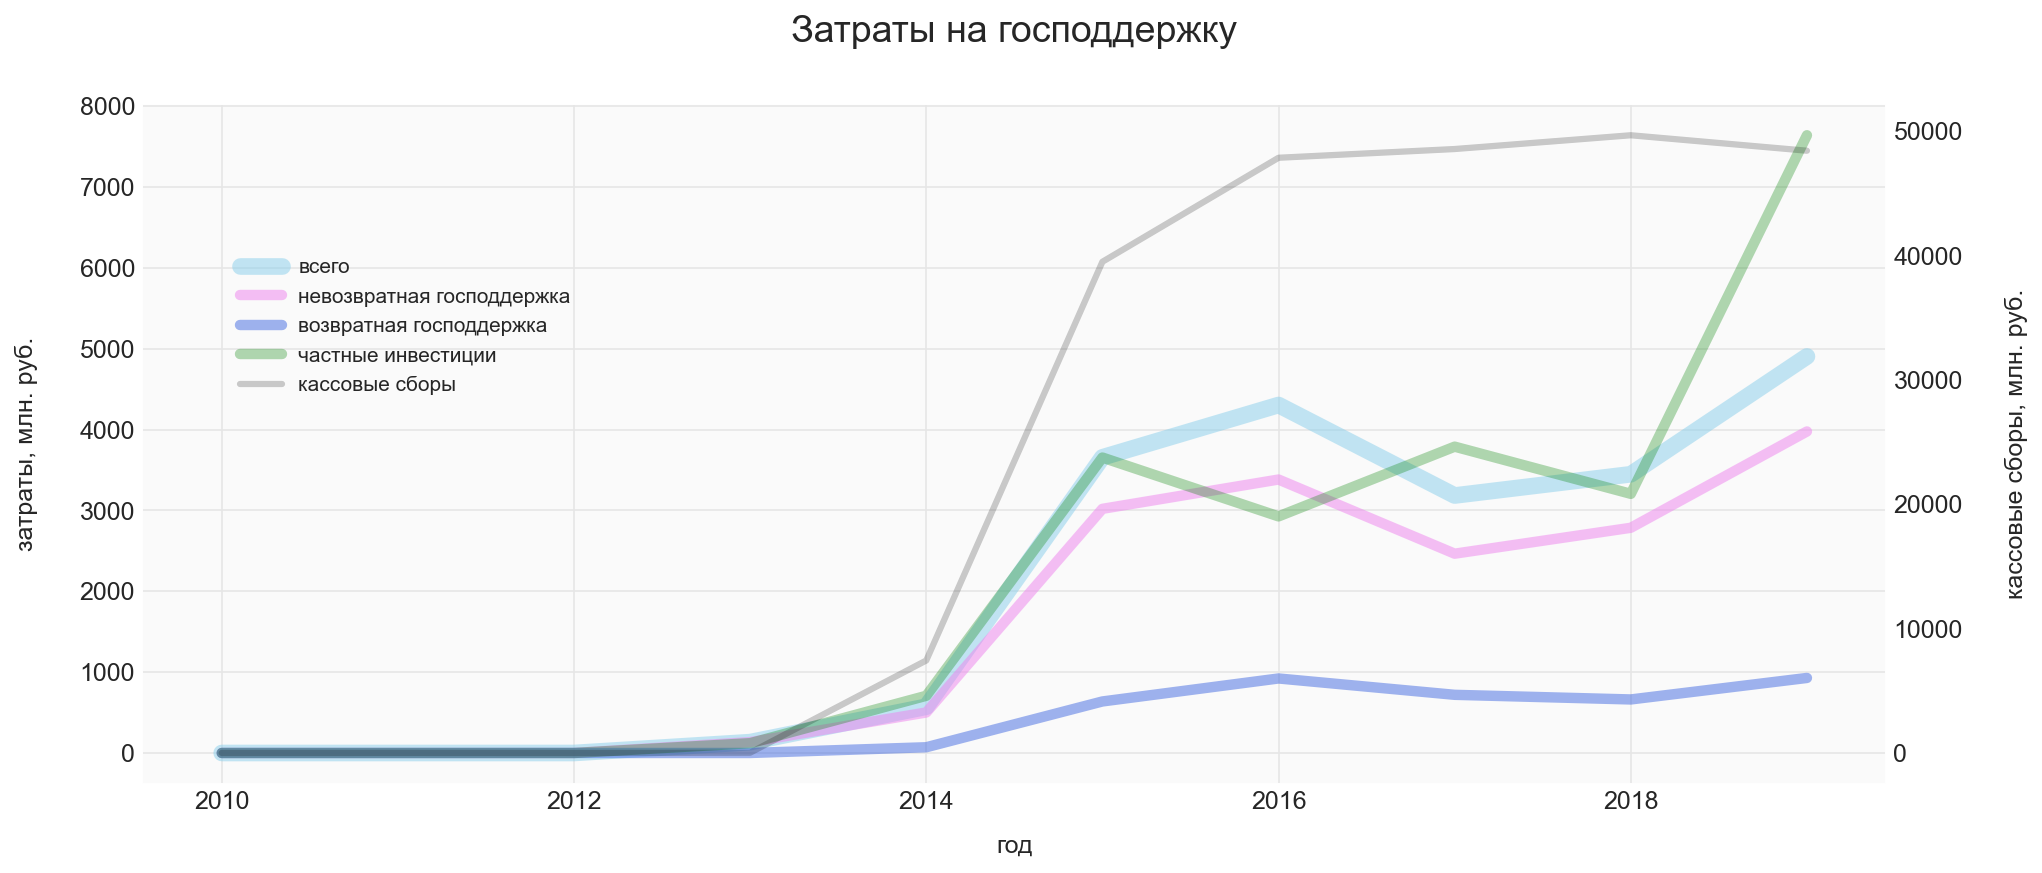

,premiere_year,support_refundable_year,support_refundable_not_year,support_total_year,income_year,budget_year,private_year,support_ref_not_part
0,2010,0.000000,0.000000,0.000000,10.331714,0.000000,0.000000,nan%
1,2011,0.000000,0.000000,0.000000,15.425754,0.000000,0.000000,nan%
2,2012,0.000000,0.000000,0.000000,7.453881,0.000000,0.000000,nan%
3,2013,0.000000,134.347945,134.347945,29.861840,255.435390,121.087445,100%
4,2014,71.000000,501.002299,572.002299,7444.996445,1279.484783,707.482484,88%
5,2015,637.153119,3019.088340,3656.241459,39497.528235,7309.669207,3653.427748,83%
6,2016,921.500000,3381.655482,4303.155482,47858.827650,7228.942748,2925.787266,79%
7,2017,719.346881,2464.624781,3183.971662,48561.185044,6972.172568,3788.200906,77%
8,2018,662.000000,2784.969465,3446.969465,49668.403134,6651.694634,3204.725169,81%
9,2019,928.000000,3976.000000,4904.000000,48425.708780,12542.866609,7638.866609,81%


In [83]:
fig, ax = plt.subplots(figsize=(15,6), dpi=plot_dpi)


# подготовка данных
df = (
      data
      .groupby('premiere_year')
      .agg(
           support_refundable_year=('support_refundable','sum'),
           support_refundable_not_year=('support_refundable_not','sum'),
           support_total_year=('support_total','sum'),
           income_year=('income','sum'),
           budget_year=('budget','sum'),
          )
      .reset_index()
      .assign(private_year = lambda df: df.budget_year - df.support_total_year)
      .assign(support_ref_not_part = lambda df: df.support_refundable_not_year / df.support_total_year)
     )

# график: общая господдержка
sns.lineplot(
             x=df.premiere_year,
             y=df.support_total_year,
             color='skyblue',
             linewidth=8,
             alpha=0.5,
            )

# график: невозвратная господдержка
sns.lineplot(
             x=df.premiere_year,
             y=df.support_refundable_not_year,
             color='violet',
             linewidth=5,
             alpha=0.5,
            )

# график: возвратная господдержка
sns.lineplot(
             x=df.premiere_year,
             y=df.support_refundable_year,
             color='royalblue',
             linewidth=5,
             alpha=0.5,
            )

# график: частные инвестиции
sns.lineplot(
             x=df.premiere_year,
             y=df.private_year,
             color='green',
             linewidth=5,
             alpha=0.3,
            )

# график: кассовые сборы
ax2 = ax.twinx()
sns.lineplot(
             x=df.premiere_year,
             y=df.income_year,
             color='black',
             linewidth=3,
             alpha=0.2,
             ax=ax2,
            )


# # тюнинг графиков

ax.set_title('Затраты на господдержку', size=18, pad=30)
ax.set_xlabel('год', size=12, labelpad=10)
ax.set_ylabel('затраты, млн. руб.', size=12, labelpad=20)
ax.tick_params(labelsize=12, length=0)

ax2.set_ylabel('кассовые сборы, млн. руб.', size=12, labelpad=20)
ax2.tick_params(labelsize=12, length=0)
ax2.grid(False)

fig.legend(['всего', 'невозвратная господдержка ', 'возвратная господдержка ','частные инвестиции','кассовые сборы'],
           title='', loc='upper left', fontsize=10, title_fontsize=10, bbox_to_anchor=(0.16, 0.73), framealpha=0.0)


space()
plt.show()


# таблица

df.style.format('{:.0%}',subset='support_ref_not_part')

> Согласно входным данным, в 2010-2012 господдержка не оказывалась.
> 
> Далее сумма господдержки быстро нарастает и, начиная с 2015 года, выходит на относительно стабильный уровень.  
> Интересно, что график общих кассовых сборов имеет резкий рост в те же годы, что и график госпомощи. Возможно, это связано с третьим фактором: например, данные о сборах в прокате стали собирать более полно.
>
> Объем невозвратной госпомощи примерно в 4 раза превосходит объем возвратной. Эта тенденция стабильна.
>
> В 2016 году господдержка превысила частные инвестиции в 1.5 раза.
>
> Частные инвестиции резко взлетели в 2019 году.

### Господдержка и кассовые сборы

Доля кассовых сборов фильмов с господдержкой от общей суммы кассовых сборов

In [84]:
data.query('support_total > 0').income.sum() / data.income.sum()

0.17436882231747272

Доля фильмов с господдержкой среди всех фильмов

In [85]:
data.query('support_total > 0').shape[0] / data.shape[0]

0.04906887378066804

> Доля кассовых сборов фильмов с господдержкой в 3.5 раза больше доли количества таких фильмов.
>
> Возможные причины:  
> - для господдержки выбираются фильмы с более обещающими кассовыми сборами;  
> - кассовые сборы фильмов с господдержкой мониторятся более тщательно;  
> - помимо прямой финансовой такие фильмы получают какую-либо дополнительную поддержку.

### Окупаемость господдержки

> **Важно!**  
> 1. Анализируются только фильмы с господдержкой.
> 1. Нельзя исключать, что господдержка направлена в том числе на некоммерческме фильмы, которые без нее вряд ли появились и никогда ее не окупят. Но поскольку в задании сказано исследовать окупаемость, будет исследовать.
> 1. Желательно провести отдельное исследование для возвратной и невозвратной господдержки, а также их суммы, но в исследовании таких размеров можно будет заблудиться. Ограничимся только общей господдержкой.
> 1. Исследование господдержки в перспективе можно расширить до отдельного исследования. Основное препятствие на данный момент — отсутствие значительной части критически важных данных: бюджета фильма и кассовых сборов. Как мы убедились выше, есть фильмы, указанные кассовые сборы которых нереально малы, а у каких-то бюджет не указан вовсе.
> 1. Приведенное ниже исследование может быть некорректным ввиду недостаточно полных данных. В частности, чтобы рассчитать окупаемость фильма, который частично профинансирован засчет господдержки, необходимо из его кассовых сборов вычесть полный бюджет, полученную разность разделить на сумму господдержки.
> 1. Чтобы частично нивелировать этот недостаток, ниже под окупаемостью принимается соотношение кассовых сборов и суммы господдержки. Будем считать, что возврат господдержки более приоритетен перед частными инвестициями, и оценим, хватает ли на это кассовых сборов.

Новое поле: окупаемость господдержки

In [86]:
data['payback'] = data.income / data.support_total

#### Окупаемость по всем фильмам в целом

In [87]:
source_columns = data.columns.to_list()     # список исходных полей датафрейма

(
 data
 .query('support_total > 0')
 .assign(support_count = lambda df: df.support_total.count())
 .assign(support_sum = lambda df: df.support_total.sum())
 .assign(budget_sum = lambda df: df.budget.sum())
 .assign(income_sum = lambda df: df.income.sum())
 .assign(payback_mean = lambda df: df.payback.mean())
 .assign(payback_median = lambda df: df.payback.median())
 .assign(payback_min = lambda df: df.payback.min())
 .assign(payback_max = lambda df: df.payback.max())
 .assign(payback_overall = lambda df: df.income_sum / df.support_sum)
 .drop(source_columns, axis=1)
 .iloc[0]
 .to_frame()
 .T
 .reset_index(drop=True)
)

,support_count,support_sum,budget_sum,income_sum,payback_mean,payback_median,payback_min,payback_max,payback_overall
0,332.000,20200.688,42240.266,42113.510,1.878,0.440,0.000,51.226,2.085


Количество фильмов, неокупивших господдержку

In [88]:
data.query('payback < 1').shape[0]

200

Количество фильмов с окупаемостью господдержки менее 10%

In [89]:
data.query('payback < 0.1').shape[0]

111

> Суммарный бюджет всех фильмов практически в точности совпадает с кассовыми сборами. Не стоит забывать, что во входных данных по ряду фильмов отсутствуют или существенно занижены данные о бюджете и кассовых сборах.

> Большая часть фильмов, **60%**,  не смогла окупить господдержку за счет кассовых сборов даже без учета частного финансирования, а **каждый третий** не смог окупить хотя бы **10%** вложений.

> Медианная окупаемость господдержки даже без учета частных инвестиций всего **44%**.

> **48%** составляет доля господдержки в общем бюджете всех фильмов, получивших ее.

#### Зависимость окупаемости от других признаков

Для примера приведена группировка по нескольким полям. В более объемном исследовании можно изучить зависимость окупаемости по любому полю или их комбинации.

Функция, выводящая статистику по господдержке в зависимости от поля для группировки

In [90]:
def support_info_by(field: str):
    
    return (
            data
            .query('support_total > 0')
            .groupby(field)
            .agg(
                 support_count=('support_total','count'),
                 support_sum=('support_total','sum'),
                 budget_sum = ('budget', 'sum'),
                 income_sum=('income','sum'),
                 payback_mean=('payback','mean'),
                 payback_median=('payback','median'),
                 payback_min=('payback','min'),
                 payback_max=('payback','max'),
                )
            .assign(payback_overall = lambda df: df.income_sum / df.support_sum)
            .fillna(0)
            .sort_values('support_sum', ascending=False)
           )

---
**premiere_year** (год премьеры фильма)

In [91]:
support_info_by('premiere_year').sort_index()

,support_count,support_sum,budget_sum,income_sum,payback_mean,payback_median,payback_min,payback_max,payback_overall
premiere_year,,,,,,,,,
2013,2,134.348,255.435,20.322,0.099,0.099,0.014,0.185,0.151
2014,16,572.002,1279.485,1017.422,1.564,0.163,0.001,13.111,1.779
2015,86,3656.241,7309.669,5785.285,1.354,0.183,0.000,17.623,1.582
2016,61,4303.155,7228.943,6081.708,1.279,0.324,0.000,12.121,1.413
2017,41,3183.972,6972.173,10865.075,3.063,1.310,0.007,21.119,3.412
2018,56,3446.969,6651.695,9934.069,2.371,0.784,0.002,21.115,2.882
2019,70,4904.000,12542.867,8409.627,2.131,0.469,0.003,51.226,1.715


> На графике объема ежегодных вложений в 2017-18 годах произошло снижение объема господдержки. Окупаемость в эти же годы наоборот выросла.

---
**type** (тип фильма)

In [92]:
support_info_by('type')

,support_count,support_sum,budget_sum,income_sum,payback_mean,payback_median,payback_min,payback_max,payback_overall
type,,,,,,,,,
художественный,300,17627.199,36966.812,36490.216,1.791,0.289,0.000,51.226,2.070
анимационный,31,2570.489,5240.454,5623.293,2.708,1.416,0.010,17.623,2.188
документальный,1,3.000,33.000,0.000,0.000,0.000,0.000,0.000,0.000


> Подавляющая доля господдержки как по объему, так и по количеству приходится на художественные фильмы.
>
> С многократным отставанием следуют анимационные фильмы, и сиротливо замыкает список господдержки единственный документальный фильм.
>
> Научно-популярным', музыкально-развлекательным и "'прочим" фильмам недосталось вообще ничего.

> Окупаемость анимационных фильмов выглядит значительно равномернее, чем художественных.

---
**genre_main** (жанр фильма)

In [93]:
support_info_by('genre_main')

,support_count,support_sum,budget_sum,income_sum,payback_mean,payback_median,payback_min,payback_max,payback_overall
genre_main,,,,,,,,,
драма,93,5314.407,11051.887,9490.844,1.022,0.127,0.000,12.621,1.786
комедия,74,3218.283,5915.587,12479.977,3.313,0.960,0.002,51.226,3.878
мультфильм,31,2461.520,5285.499,5622.014,2.707,1.416,0.002,17.623,2.284
фантастика,11,1406.000,2193.101,1718.204,1.320,1.384,0.006,4.153,1.222
фэнтези,11,1032.900,2340.124,995.837,0.791,0.441,0.000,3.603,0.964
история,4,1020.000,2145.062,1455.468,1.104,1.249,0.230,1.687,1.427
триллер,15,769.645,1290.961,700.450,0.693,0.123,0.002,4.704,0.910
приключения,7,696.000,3374.742,1205.597,4.793,1.887,0.012,21.119,1.732
,16,688.969,942.961,1481.749,1.194,0.019,0.001,17.009,2.151


> Наибольшей популярностью у господдержки пользуются драмы и комедии.  
> Детское кино — среди замыкающих. Значит, не показалось, что в ужасы, боевики и криминал государство вкладывает охотнее, чем в детское кино.

> Детское кино к тому же замыкает рейтинг по окупаемости. Впрочем, есть подозрение, что в этом случае сильно занижены данные о кассовых сборах.  
> Другой антилидер рейтинга окупаемости – мелодрама. Неудивительно: кто же такое смотрит в кинотеатрах?  
> Лидеры окупаемости – спорт, биография и комедии.

---
**age_rating** (возрастной рейтинг фильма)

In [94]:
support_info_by('age_rating')

,support_count,support_sum,budget_sum,income_sum,payback_mean,payback_median,payback_min,payback_max,payback_overall
age_rating,,,,,,,,,
C_12+,106,7799.394,15251.946,19957.964,2.697,0.671,0.000,51.226,2.559
D_16+,125,5569.053,11513.592,7658.463,1.434,0.194,0.001,21.115,1.375
B_6+,65,5546.374,12320.906,13383.992,2.017,0.902,0.005,17.623,2.413
E_18+,28,1012.347,2250.837,560.159,0.550,0.059,0.000,3.798,0.553
A_0+,8,273.520,902.985,552.933,1.773,1.612,0.002,4.478,2.022


> С фильмами для самых маленьких ситуация знакома: денег нет, но вы держитесь.

> Почти все возрастные категории условно-прибыльны (без учета частных инвестиций), но неожиданно удивила категория **"18+"** – рейтиг окупаемости едва перевалил за 50%. Неужели зрителей отпугивает предупреждающая надпись на афише? Как вариант объяснения: в кинотеатр ходят с детьми. Либо дело не в категории, а просто сами фильмы того не стоят.

---
**director_main** (режиссер фильма)

In [95]:
support_info_by('director_main').head(10)

,support_count,support_sum,budget_sum,income_sum,payback_mean,payback_median,payback_min,payback_max,payback_overall
director_main,,,,,,,,,
ф.бондарчук,2,750.000,944.000,1038.321,4.153,4.153,4.153,4.153,1.384
н.хомерики,3,660.000,883.705,618.143,1.688,1.124,0.186,3.753,0.937
а.кравчук,1,500.000,980.000,717.703,1.435,1.435,1.435,1.435,1.435
р.давлетьяров,5,459.848,770.430,299.263,0.486,0.185,0.086,1.661,0.651
а.мизгирев,1,450.000,684.201,364.285,0.810,0.810,0.810,0.810,0.810
н.лебедев,1,442.104,635.284,1402.255,3.172,3.172,3.172,3.172,3.172
а.мегердичев,1,400.000,590.192,2779.686,6.949,6.949,6.949,6.949,6.949
д.дьяченко,4,351.000,780.695,2404.899,6.679,4.313,1.539,16.550,6.852
а.цицилин,3,350.000,852.163,530.326,2.073,1.544,0.197,4.478,1.515


Количество режиссеров, неокупивших господдержку

In [96]:
support_info_by('director_main').query('payback_overall < 1').shape[0]

184

Количество режиссеров с окупаемостью господдержки менее 10%

In [97]:
support_info_by('director_main').query('payback_overall < 0.1').shape[0]

107

> Самый финансируемый государством режиссер – Бондарчук. Кто бы сомневался. Частные инвестиции он едва окупает, а вот господдержка, похоже, уходит в трубу.
>
> Впрочем, идущий следом Хомерики (кто это?!) не способен даже на это – полный провал в прокате. Но вдруг он фильмы хорошие снимает? Надо проверить.
>
> Эту и остальные фамилии в топ-10 я впервые вижу, для знакомства с ними нужно провести отдельное исследование.

> В целом по режиссерам даже без учета частных инвестиций 184 не смогли окупить господдержку, а 107 не вышли даже на 10%-й уровень окупаемости.

## Вывод

### Краткий обзор проведенной работы

В данном исследовании были изучены данные, опубликованные на портале открытых данных Министерства культуры, включая информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск.

Оценено качество этих данных. Выполнена проверка на пропуски, ошибки и дубликаты. Проведена работа по улучшению качества входных данных: коррекция типов данных, исправление ошибок, удаление дубликатов, добавление новых полей.

Даны рекомендации по результатам исследования. Определены потенциальные риски и возможности их устранения. Даны рекомендации по дальнейшему развитию исследования.

### Результаты анализа

**Входные данные**

В результате оценки полноты и достоверности представленных данных, можно отметить их самый главный недостаток: **данные о бюджете фильма и кассовых сборов являются неполными, а где-то недостоверными**. Это существенно влияет на качество исследования. Восстановление этих данных расчетным путем вряд ли улучшит исследование, а возможно даже ухудшит.

Отмечается почти полное отсутствие важных данных до 2015 года, что существенно сокращает анализируемый период.

**Исследовательский анализ**

Исследованы:  
- [ежегодное количество прьемьер](#id_premier_annualy), в том числе с привязкой к кассовым сборам;
- [ежегодная динамика кассовых сборов](#id_income_annualy);
- [влияние возрастного рейтинга на кассовые сборы](#id_age_rating_annualy);
- [госсподдержка](#id_support), включая оценку окупаемости в разных группах;

 ### Рекомендации и риски
 
Качество данных вызывает сомнение. Заявлено, что источник данных – портал открытых данных Министерства культуры. Однако выборочная проверка показывает несоответстие: где-то несовпадают возрастные рейтинги, где-то дата прокатного удостоверения. Данные о бюджете и кассовых сборах на указанном портале вообще отсутствуют. Их источник во входных данных остается под вопросом.

Необходим источник более полных и точных данных о бюджете и кассовых сборах фильма. Многие выводы опираются на эти данные, поэтому их качество критически важно.

В зависимости от дальнейших целей может понадобиться очистка данных от выбросов. Например, много выбросов в данных о бюджете фильма.

Некоторые поля представляют собо набор значений единой строкой. Для продуктивной работы с такими полями необходимо выделить данные из них в отдельные таблицы. Причем, для корректой связи между таблицами вида "многие-к-многим" потребуются дополнительные вспомогательные таблицы.

Возможные темы для дальнейших исследований:
- более детальное и всестороннее исследование господдержки;
- бюджет: хвост выбивающихся значений как отдельный датасет;
- поиск различий в зависимости от источника господдержки;
- очень щедрая господдержка некоторых фильмов и некоторых режиссеров.

## The End